# Cuda setup
Check if cuda is available.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Import data from source
METHOD 1: install yfinance in the environment hosting python and jupyter. I used Anaconda, and installed through conda terminal into my environment.

*pip install yfinance*

Use the yfinance API to retrieve company data

In [2]:
# yahoo finance api to collect stock data
import yfinance as yf
import os

# datetime imports to work with dates
from datetime import date
from dateutil.relativedelta import relativedelta

# alpaca api to collect stock data
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit

# Process data from csv files
Use pandas library for processing files

Use matplotlib to display graphs and visualizations.

Use torch to create and train a RNN model.

In [3]:
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

In [4]:
#Change directory for Lorne's jupyter notebook
# I am mixing windows and wsl on windows so I need to manaually change the directory, so you won't need to when you run it
if True:
    # See files in current directory
    import os

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    for file_name in files:
        print(file_name)

    %cd "/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS"

    current_directory = os.getcwd()
    print(current_directory)

    entries = os.listdir('.')
    files = [entry for entry in entries if os.path.isfile(entry)]

    # Print the names of the files
    for file_name in files:
        print(file_name)

C:\Users\chr1s\Downloads
AMD1_intraday.csv
AMD_intraday.csv
AMD_intraday1.csv
AMD_intraday2.csv
AMD_intraday3.csv
build_cnn.ipynb
CSVsetup.ipynb
debug.log
desktop.ini
first_try.ipynb
ideaIU-2024.3.3.exe
MariaResearch.sql
model_trained.pt
openjfx-24.0.1_windows-x64_bin-sdk.zip
RNN (0721 Normalization).ipynb
RNN (0721).ipynb
RNN (0722).ipynb
RNN(2).ipynb
RNN(3).ipynb
RNN.ipynb
ubuntu-24.04.2-wsl-amd64.gz
untitled.txt
WebStorm-2024.3.3.exe
[WinError 3] The system cannot find the path specified: '/mnt/c/Users/LPC/Documents/GitHub/CSCI611-NNSTOCKS'
C:\Users\chr1s\Downloads
C:\Users\chr1s\Downloads
AMD1_intraday.csv
AMD_intraday.csv
AMD_intraday1.csv
AMD_intraday2.csv
AMD_intraday3.csv
build_cnn.ipynb
CSVsetup.ipynb
debug.log
desktop.ini
first_try.ipynb
ideaIU-2024.3.3.exe
MariaResearch.sql
model_trained.pt
openjfx-24.0.1_windows-x64_bin-sdk.zip
RNN (0721 Normalization).ipynb
RNN (0721).ipynb
RNN (0722).ipynb
RNN(2).ipynb
RNN(3).ipynb
RNN.ipynb
ubuntu-24.04.2-wsl-amd64.gz
untitled.txt
WebSto

# Helper functions
StockDataset class to hold pytorch data

In [5]:
#HYPERPARAMETER
training_percentage = 6
#HYPERPARAMETER
valid_percentage = 2
#HYPERPARAMETER
testing_percentage = 2
class StockDataset(torch.utils.data.Dataset[float]):
    def __init__(self, sequences, targets):
        super(StockDataset).__init__()
        self.sequences = sequences
        self.targets = targets
    def __len__(self):
        return len(self.sequences)    
    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index], dtype=torch.float32).unsqueeze(-1)#sequence at index 
        target = torch.tensor(self.targets[index], dtype=torch.float32)#test_value at index
        return sequence, target
        
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, nonlinearity='tanh', bias=True, batch_first=True, dropout=0.0):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, nonlinearity=nonlinearity, bias=bias, 
            batch_first=batch_first, dropout=dropout, bidirectional=False, device=None, dtype=None)
        self.fc = nn.Linear(128, 1)
        
    def forward(self, x):
        self.output, self.hidden = self.rnn(x)
        prediction = self.fc(self.output[:, -1, :])
        return prediction.squeeze(-1)

# get_yahoo_stock_data(name, interval="5m", period="7d")

unction that calls yfinance to get stock data from a defined time period

@params stock_name: name of the stock to get data for

@params interval: interval of the data, default is 15 minutes

@params months: number of months to get data for

In [6]:
# Generate stock price data from yahoo finance 
def get_yahoo_stock_data(name, interval="5m", period="7d"):
    data = yf.download(name, interval=interval, period=period)
    return data

# get_alpaca_stock_data(name, interval="15", months="6") 

function calls alpaca api to get stock data for a defined time period starting from June 1st 2021

@params stock_name: name of the stock to get data for

@params interval: interval of the data, default is 15 minutes

@params months: number of months to get data for

In [7]:
# Generate stock price data from alpaca
def get_alpaca_stock_data(name, interval="15", months="6"):
    name_of_file = name + "_intraday1.csv"

    start_date = date(2021, 6, 1)
    end_date = start_date + relativedelta(months=int(months))  # Adds months

    api = REST('PKJ41QP5QU0TYS4S1BYB', 'o5HVFGx0XWSMoMyeQdRJwG1apYXtuMNcguWpjqqe')

    data = api.get_bars(name, TimeFrame(int(interval), TimeFrameUnit.Minute), start_date, end_date, adjustment='raw').df

    data = data.rename(columns={"close": "Close", "open": "Price", "high": "High", "low": "Low", "volume": "Volume", "datetime": "Datetime", "ticker": "Ticker"})

    data.to_csv(name_of_file)

    return name_of_file

# plot_loss(training_loss_array, validation_loss_array, epochs)

Creates a matplotlib plot of the training and validation loss

@params training_loss_array: Array of training loss values

@params validation_loss_array: Array of validation loss values

@params epochs: Number of epochs

In [8]:
# Creates a matplotlib plot of the training and validation loss
def plot_loss(training_loss_array, validation_loss_array, epochs):
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(range(1, int((epochs)/10) + 1), training_loss_array, marker='o', linestyle='-', color='b', label='Training Loss')

    # Plot validation loss
    plt.plot(range(1, int((epochs)/10) + 1), validation_loss_array, marker='x', linestyle='--', color='r', label='Validation Loss')

    # Add title and labels
    plt.title('Training vs Validation Loss Over Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add x-axis ticks
    plt.xticks(range(1, (int((epochs + 1)/10)+1), 1))

    # Show the plot
    plt.show()

# plot_target_vs_predicted_values(target_values_array, predicted_values_array, batch_size)

Creates a matplotlib plot of the target values vs the predicted values.

@params target_values_array: Array of actual real values of selected stock for testing phase of RNN

@params predicted_values_array: Array of predicted values generated by RNN

@params batch_size: Number of values in target_values_array and predicted_values_array

In [9]:
# Creates a matplotlib plot of the training and validation loss
def plot_target_vs_predicted_values(target_values_array, predicted_values_array, batch_size):
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot target values
    plt.plot(range(1, batch_size + 1), target_values_array, marker='o', linestyle='-', color='b', label='Target Values')

    # Plot predicted values
    plt.plot(range(1, batch_size + 1), predicted_values_array, marker='x', linestyle='--', color='r', label='Predicted Values')

    # Add title and labels
    plt.title('Target vs Predicted Stock Values')
    plt.xlabel('Time')
    plt.ylabel('Stock Value')

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add x-axis ticks
    plt.xticks(range(1, batch_size, 1))

    # Show the plot
    plt.show()

# plot_target_vs_predicted_values(target_values_array, predicted_values_array, batch_size)

Creates a matplotlib plot of the target values vs the predicted values.

@params target_values_array: Array of actual real values of selected stock for testing phase of RNN

@params predicted_values_array: Array of predicted values generated by RNN

@params batch_size: Number of values in target_values_array and predicted_values_array

In [10]:
def standardize_2d(data):
    """
    Standardizes a 2D array of data.
    
    Parameters:
    data (numpy.ndarray): A 2D array of data to be standardized.
    
    Returns:
    numpy.ndarray: The standardized data.
    """
    average_val = np.mean(data)
    std_val = np.std(data)
    standardized_data = (data - average_val) / std_val
    return standardized_data

# Display relevant information for formatting purposes

In [11]:
class RNN_initializer:
    #HYPERPARAMETER
    def __init__(self, retrieve, name, recomp, nval, ival, pval, sequence_len, batch_size, num_workers, epochs, learning_rate, lr_scheduler_rate, beta1, beta2):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.learning_rate = learning_rate
        self.lr_scheduler_rate = lr_scheduler_rate
        self.beta1 = beta1
        self.beta2 = beta2
        if(retrieve == True):
            if (stock_data_source == "yahoo"):
                self.csv_name = self.retrieve_csv(name, recomp, nval, str(ival[0])+ival[1], str(pval[0])+pval[1])
            else:
                self.csv_name = get_alpaca_stock_data(name, stock_interval, stock_period)
        else:
            self.csv_name = name
        self.df=pd.read_csv(name + "_intraday1.csv")
        #format data, and prepare it for RNN
        if(stock_data_source == "yahoo"):
            price = self.df['Close'].to_list()[2:]
            self.axis_labels = self.df['Price'].to_list()[2:]
        else:
            price = self.df['Close'].to_list()[1:]
            self.axis_labels = self.df['Price'].to_list()[1:]
        date_format_with_time = "%Y-%m-%d %H:%M:%S"
        price_inputs = [float(x) for x in price]
        price_inputs = standardize_2d(price_inputs)
        sequence_length = sequence_len
        #Training sets
        train_seq = []
        train_tar = []
        #Validation sets
        valid_seq = []
        valid_tar = []
        #Testing sets
        test_seq = []
        test_tar = []
        #choose a selected time range
        #HYPERPARAMETERS
        train_range = (len(price_inputs)//10 * training_percentage)
        valid_range_beg = train_range
        valid_range_end = train_range + (len(price_inputs)//10 * valid_percentage)
        test_range_beg = valid_range_end
        test_range_end = valid_range_end + (len(price_inputs)//10 * testing_percentage)
        
        #generate sequences and targets list for loading data
        for i in range(train_range - sequence_length):
            seq = price_inputs[i:i+sequence_length]
            train_seq.append(seq)
            temp = price_inputs[i+sequence_length]
            train_tar.append(temp)
        for j in range(valid_range_beg, valid_range_end-sequence_length):
            seq = price_inputs[j:j+sequence_length]
            valid_seq.append(seq)
            temp = price_inputs[j+sequence_length]
            valid_tar.append(temp)
        for k in range(test_range_beg, test_range_end-sequence_length):
            seq = price_inputs[k:k+sequence_length]
            test_seq.append(seq)
            temp = price_inputs[k+sequence_length]
            test_tar.append(temp)
        train_data = StockDataset(train_seq, train_tar)
        valid_data = StockDataset(valid_seq, valid_tar)
        test_data = StockDataset(test_seq, test_tar)
        
        self.train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
        self.valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
        self.test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
    # retreive_csv is a file that allows the user to extract stock data from yahoo finance.
    # @param: name, name of file
    # @param: recomp, indicates if file needs to be recompiled
    # @param: num, indicates which file need to be recompiled
    def retrieve_csv(self, name, recomp, nval, ival, pval):
        # Example: Get 1-minute intraday data for Apple (AAPL) for 1 day
        data = get_yahoo_stock_data(stock_name, stock_interval, stock_period)
        ext = ".csv"
        pt2 = "_intraday"
        num = 1;
        file_name = name + pt2 + str(num) + ext
        found = False
        if(recomp!=True):
            while(found!=True):
                if os.path.isfile(file_name):
                    num+=1
                    file_name = name + pt2 + str(num) + ext
                else:
                    found = True
        else:
            if(nval >= 1):
                file_name = name + pt2 + str(nval) + ext
            else:
                file_name = name + pt2 + ext
        data.to_csv(file_name)
        return file_name

    def display_fig(self):
        plt.figure(figsize=(20, 20))
        plt.title(name + " Intraday Stock Price")
        plt.plot(self.axis_labels, self.price_inputs)
        plt.xlabel("time")
        plt.ylabel("price")
        plt.xticks(self.axis_labels[::26])
        plt.yticks(self.price_inputs[::30])
        plt.show()

    def show_df_info(self):
        self.df.head(15)
        self.df.tail(10)
        print("Row count: " + str(len(self.df)))
    def init_RNN(self):
        rnn = RNN()
        return rnn
    def trainAndTest(self, rnn):
        #RNN model
        # move tensors to GPU if CUDA is available
        min_loss = np.inf

        if train_on_gpu:
            rnn.cuda()
        #use MSELoss instead of MSEAbsoluteLoss (predicting next price compared to next change)
        error = nn.MSELoss()
        # specify optimizer
        optimizer = torch.optim.Adam(rnn.parameters(), lr=self.learning_rate, betas=(beta1, beta2))
        #optimizer = optim.SGD(model.parameters(), lr=0.01)
        #self.price_tensor = torch.tensor(self.sequences, dtype=torch.float32).unsqueeze(-1)#input 
        #self.y_tensor = torch.tensor(self.test_vals, dtype=torch.float32)#test_values
        # Learning rate scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=self.lr_scheduler_rate, patience=10)
        valid_loss_min = np.inf
        for epoch in range(epochs):
            train_loss = 0.0
            valid_loss = 0.0
            #TRAINING
            rnn.train()
            for batch_idx, (data, target) in enumerate(self.train_loader):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = rnn(data)
                # calculate the batch loss
                loss_train = error(output, target)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss_train.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                train_loss += loss_train.item()*data.size(0)
                if (loss_train < min_loss):
                    min_loss = loss_train
                    #torch.save(rnn.state_dict(), "rnn.pth")

            scheduler.step(train_loss)  # Update learning rate

    
            ######################    
            # validate the model #
            ######################
            rnn.eval()
            for batch_idx, (data, target) in enumerate(self.valid_loader):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = rnn(data)
                # calculate the batch loss
                loss_valid = error(output, target)
                # perform a single optimization step (parameter update)
                valid_loss += loss_valid.item()*data.size(0)
                if (loss_valid < min_loss):
                    min_loss = loss_valid
                    #torch.save(rnn.state_dict(), "rnn.pth")
            # calculate average losses
            train_loss = train_loss/len(self.train_loader.dataset)
            valid_loss = valid_loss/len(self.valid_loader.dataset)
            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and (epoch+1) % 10 == 0:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(rnn.state_dict(), 'model_trained.pt')
                valid_loss_min = valid_loss
            #remove +1 possibly
            if (epoch+1) % 10 == 0:
                lr = optimizer.param_groups[0]["lr"]
                print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item():.6f}, Validation Loss: {loss_valid.item():.6f}")
                training_loss_array.append(float(loss_train.item()))
                validation_loss_array.append(float(loss_valid.item()))
        return min_loss
        


In [12]:
#Stock variables used when collecting stock data
#Choose which api to use to grab stock data, either "yahoo" or "alpaca"
stock_data_source = "alpaca"
sequence_len = 4
#Loss array used to store loss values for each 10 epochs, reset each set of hyperparameters
training_loss_array = []
validation_loss_array = []
test_loss = np.inf

#HYPERPARAMETER
#Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#HYPERPARAMETER
#Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="12" #months
    epochs = 150
    lr_scheduler_rate = 0.1
    beta1 = 0.9
    #changed
    #beta1 = 0.95
    beta2 = 0.999

batch_size = 16
num_workers = 0

# Setting up control

In [13]:
rnnControlSetup = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], 
    pval=[7,"d"],sequence_len=sequence_len, batch_size=16, num_workers=0, epochs=150, learning_rate=0.001, 
    lr_scheduler_rate=0.1, beta1=0.9, beta2=0.999)
rnnControl = rnnControlSetup.init_RNN()

# Test the lr change



-------------------------------------------------------------------------------
Learning rate:  0.005    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.633891).  Saving model ...
Epoch 10/150, Training Loss: 0.044336, Validation Loss: 0.585424
Epoch 20/150, Training Loss: 0.203228, Validation Loss: 1.868154
Validation loss decreased (0.633891 --> 0.158876).  Saving model ...
Epoch 30/150, Training Loss: 0.025342, Validation Loss: 0.183133
Validation loss decreased (0.158876 --> 0.033409).  Saving model ...
Epoch 40/150, Training Loss: 0.006463, Validation Loss: 0.025317
Validation loss decreased (0.033409 --> 0.022835).  Saving model ...
Epoch 50/150, Training Loss: 0.001897, Validation Loss: 0.022763
Epoch 60/150, Training Loss: 0.002855, Validat

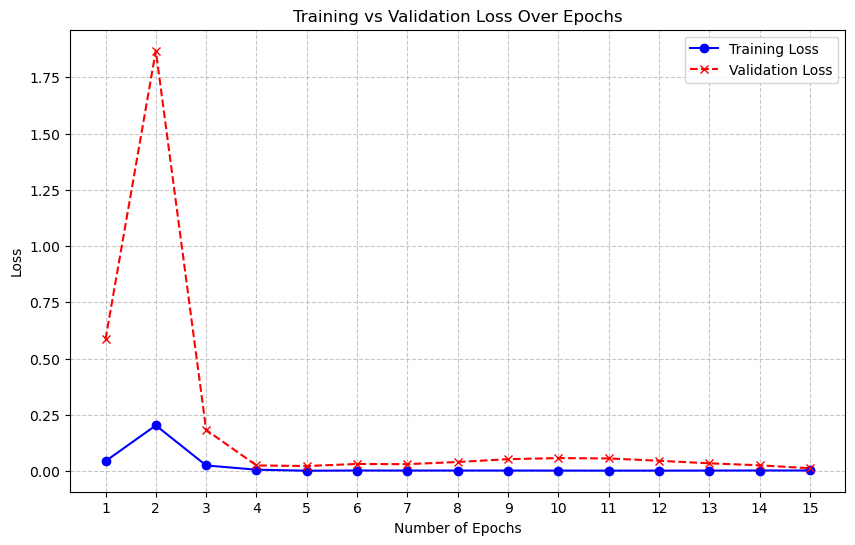



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 1.301146).  Saving model ...
Epoch 10/150, Training Loss: 0.060118, Validation Loss: 1.360815
Validation loss decreased (1.301146 --> 0.038504).  Saving model ...
Epoch 20/150, Training Loss: 0.019716, Validation Loss: 0.039984
Epoch 30/150, Training Loss: 0.005482, Validation Loss: 0.070349
Validation loss decreased (0.038504 --> 0.017664).  Saving model ...
Epoch 40/150, Training Loss: 0.003181, Validation Loss: 0.011341
Epoch 50/150, Training Loss: 0.001746, Validation Loss: 0.049063
Epoch 60/150, Training Loss: 0.002333, Validation Loss: 0.096317
Validation loss decreased (0.017664 --> 0.015705).

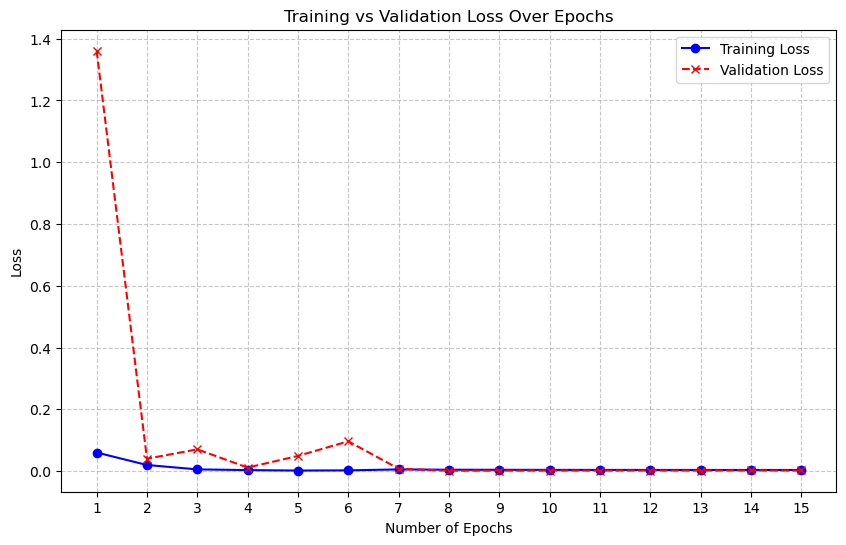



-------------------------------------------------------------------------------
Learning rate:  0.0005    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.330469).  Saving model ...
Epoch 10/150, Training Loss: 0.114781, Validation Loss: 0.231418
Validation loss decreased (0.330469 --> 0.003375).  Saving model ...
Epoch 20/150, Training Loss: 0.016185, Validation Loss: 0.000415
Validation loss decreased (0.003375 --> 0.002359).  Saving model ...
Epoch 30/150, Training Loss: 0.000483, Validation Loss: 0.000735
Epoch 40/150, Training Loss: 0.000547, Validation Loss: 0.000851
Validation loss decreased (0.002359 --> 0.002315).  Saving model ...
Epoch 50/150, Training Loss: 0.000624, Validation Loss: 0.001142
Validation loss decreased (0.002315 --> 0.002

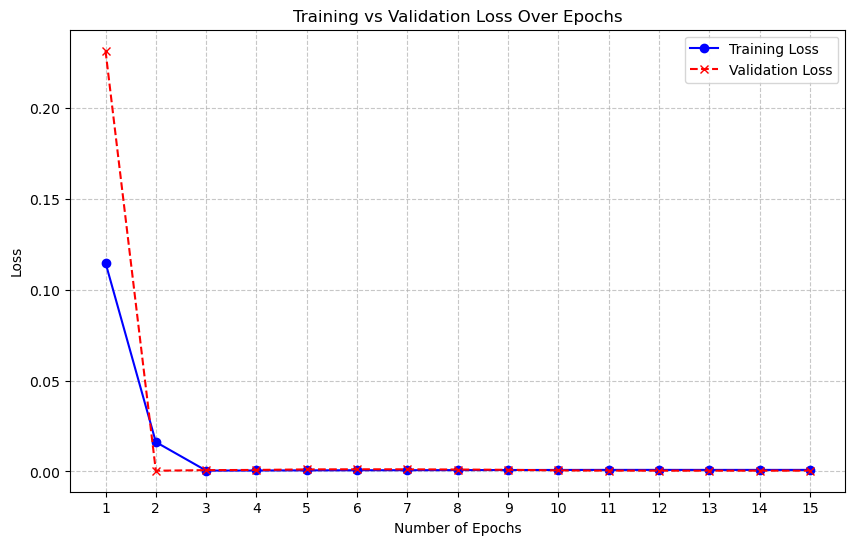



-------------------------------------------------------------------------------
Learning rate:  0.0001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004313).  Saving model ...
Epoch 10/150, Training Loss: 0.004835, Validation Loss: 0.000950
Epoch 20/150, Training Loss: 0.012690, Validation Loss: 0.002833
Epoch 30/150, Training Loss: 0.006229, Validation Loss: 0.002937
Validation loss decreased (0.004313 --> 0.002422).  Saving model ...
Epoch 40/150, Training Loss: 0.003712, Validation Loss: 0.001214
Validation loss decreased (0.002422 --> 0.001997).  Saving model ...
Epoch 50/150, Training Loss: 0.002745, Validation Loss: 0.000835
Validation loss decreased (0.001997 --> 0.001791).  Saving model ...
Epoch 60/150, Training Loss: 0.002181, Valida

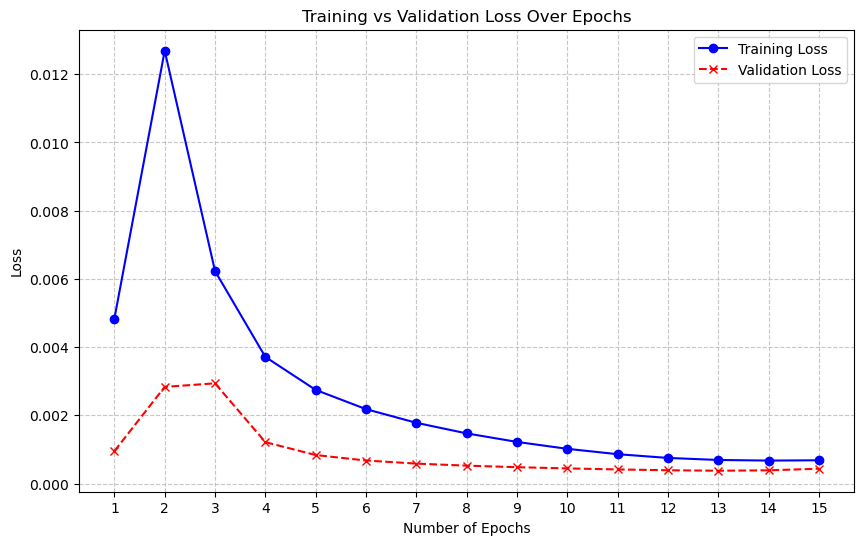



-------------------------------------------------------------------------------
Learning rate:  5e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.006085).  Saving model ...
Epoch 10/150, Training Loss: 0.006545, Validation Loss: 0.003853
Validation loss decreased (0.006085 --> 0.005160).  Saving model ...
Epoch 20/150, Training Loss: 0.008350, Validation Loss: 0.001153
Validation loss decreased (0.005160 --> 0.004202).  Saving model ...
Epoch 30/150, Training Loss: 0.006701, Validation Loss: 0.001209
Validation loss decreased (0.004202 --> 0.003467).  Saving model ...
Epoch 40/150, Training Loss: 0.005408, Validation Loss: 0.001153
Validation loss decreased (0.003467 --> 0.002873).  Saving model ...
Epoch 50/150, Training Loss: 0.004396, Val

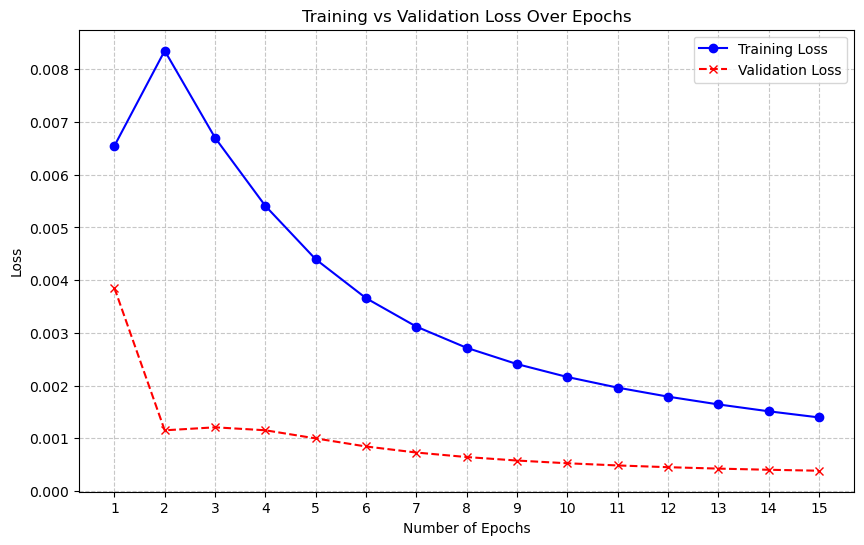



-------------------------------------------------------------------------------
Learning rate:  1e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004269).  Saving model ...
Epoch 10/150, Training Loss: 0.008910, Validation Loss: 0.000709
Validation loss decreased (0.004269 --> 0.003115).  Saving model ...
Epoch 20/150, Training Loss: 0.004870, Validation Loss: 0.000621
Validation loss decreased (0.003115 --> 0.002689).  Saving model ...
Epoch 30/150, Training Loss: 0.003572, Validation Loss: 0.000559
Validation loss decreased (0.002689 --> 0.002417).  Saving model ...
Epoch 40/150, Training Loss: 0.002817, Validation Loss: 0.000518
Validation loss decreased (0.002417 --> 0.002213).  Saving model ...
Epoch 50/150, Training Loss: 0.002310, Val

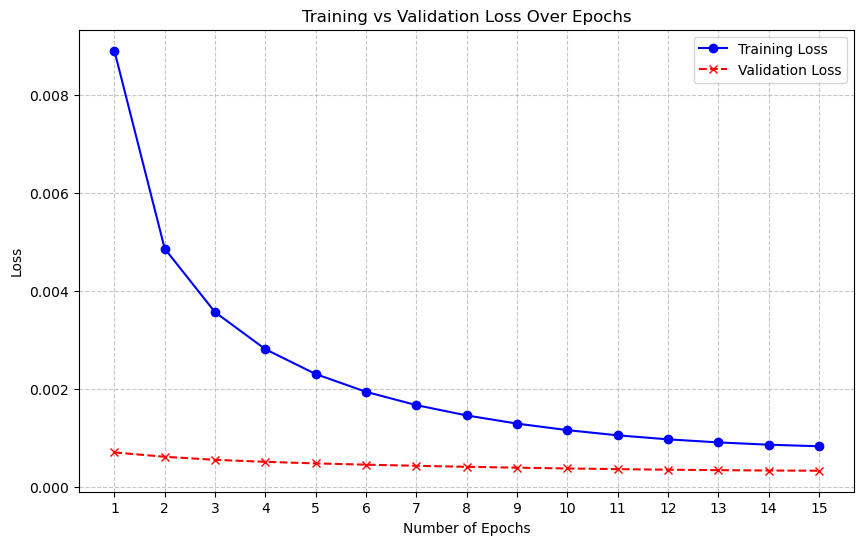



Best learning rate:  1e-05    Loss:  tensor(1.5402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best learning rate:  5e-05    Loss:  tensor(1.5787e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [14]:
skip_this_step = False

if not skip_this_step:
    #test various learning rates
    learning_rate_list = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001] #revert later for hyperparameter testing, the first few values are not good current set of hyperparameters
    #learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
    best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_lr_in_loop = np.inf
    repeated_loops_per_lr = 1
    bestRNN_lr_Setup = [rnnControlSetup,None]
    bestRNN_lr = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for lr in learning_rate_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len, batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_lr):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_lr_in_loop > loss:
                best_lr_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_lr_in_loop < best_lr[0][0]:
            best_lr[1] = best_lr[0]
            best_lr[0] = [best_lr_in_loop, lr]
            bestRNN_lr[1] = bestRNN_lr[0]
            bestRNN_lr[0] = bestRNN_in_loop
            bestRNN_lr_Setup[1] =  bestRNN_lr_Setup[0] 
            bestRNN_lr_Setup[0] =  rnnSetup
            #if 
        elif best_lr_in_loop < best_lr[1][0]:
            best_lr[1] = [best_lr_in_loop, lr]
            bestRNN_lr[1] = bestRNN_in_loop
            bestRNN_lr_Setup[1] =  rnnSetup
        best_lr_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest learning rate: ", best_lr[0][1], "   Loss: ", best_lr[0][0])
    print("Second best learning rate: ", best_lr[1][1], "   Loss: ", best_lr[1][0])

skip_this_step = False

# Test beta1 value effect



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.45 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.005132).  Saving model ...
Epoch 10/150, Training Loss: 0.010903, Validation Loss: 0.001161
Validation loss decreased (0.005132 --> 0.003526).  Saving model ...
Epoch 20/150, Training Loss: 0.005721, Validation Loss: 0.000797
Validation loss decreased (0.003526 --> 0.002976).  Saving model ...
Epoch 30/150, Training Loss: 0.004110, Validation Loss: 0.000668
Validation loss decreased (0.002976 --> 0.002638).  Saving model ...
Epoch 40/150, Training Loss: 0.003193, Validation Loss: 0.000592
Validation loss decreased (0.002638 --> 0.002393).  Saving model ...
Epoch 50/150, Training Loss: 0.002593, Va

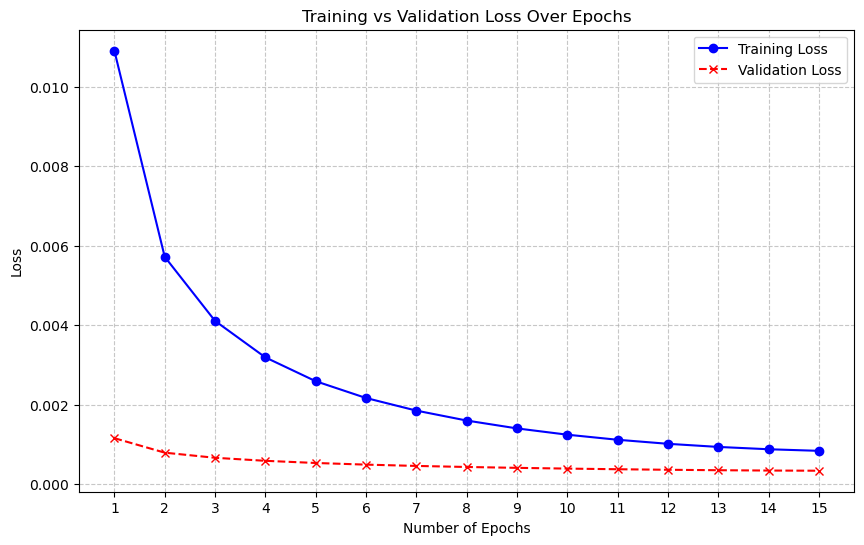



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.7 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004315).  Saving model ...
Epoch 10/150, Training Loss: 0.007677, Validation Loss: 0.001278
Validation loss decreased (0.004315 --> 0.003060).  Saving model ...
Epoch 20/150, Training Loss: 0.004066, Validation Loss: 0.000787
Validation loss decreased (0.003060 --> 0.002620).  Saving model ...
Epoch 30/150, Training Loss: 0.002973, Validation Loss: 0.000636
Validation loss decreased (0.002620 --> 0.002351).  Saving model ...
Epoch 40/150, Training Loss: 0.002357, Validation Loss: 0.000557
Validation loss decreased (0.002351 --> 0.002158).  Saving model ...
Epoch 50/150, Training Loss: 0.001960, Val

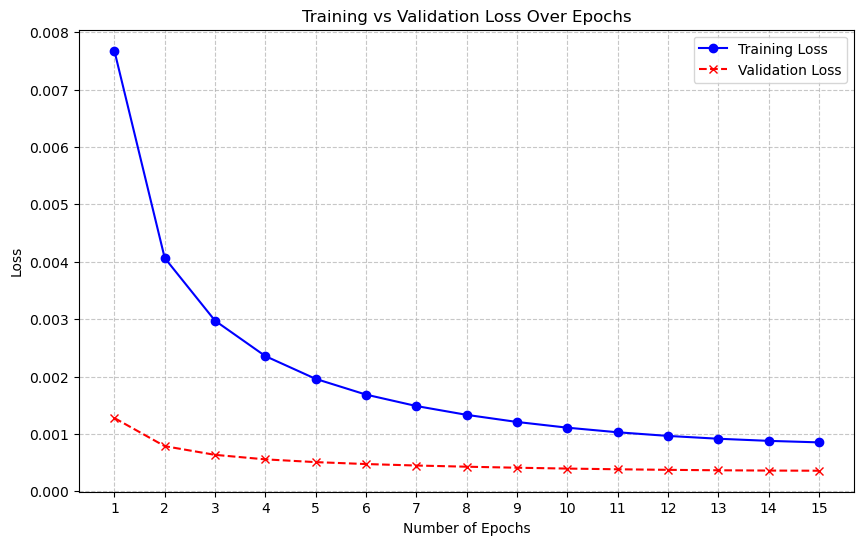



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004378).  Saving model ...
Epoch 10/150, Training Loss: 0.008572, Validation Loss: 0.000900
Validation loss decreased (0.004378 --> 0.003238).  Saving model ...
Epoch 20/150, Training Loss: 0.004804, Validation Loss: 0.000687
Validation loss decreased (0.003238 --> 0.002828).  Saving model ...
Epoch 30/150, Training Loss: 0.003665, Validation Loss: 0.000608
Validation loss decreased (0.002828 --> 0.002549).  Saving model ...
Epoch 40/150, Training Loss: 0.002964, Validation Loss: 0.000554
Validation loss decreased (0.002549 --> 0.002336).  Saving model ...
Epoch 50/150, Training Loss: 0.002474, Val

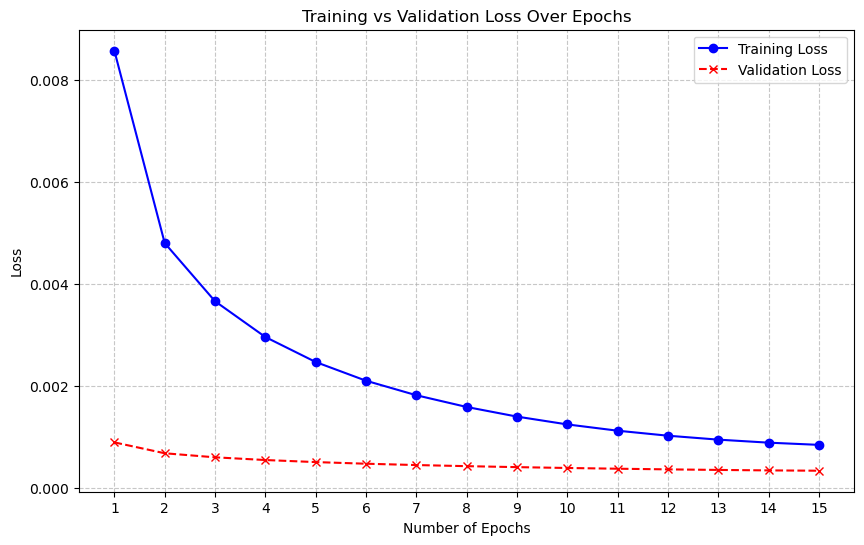



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004407).  Saving model ...
Epoch 10/150, Training Loss: 0.009015, Validation Loss: 0.000796
Validation loss decreased (0.004407 --> 0.003240).  Saving model ...
Epoch 20/150, Training Loss: 0.005017, Validation Loss: 0.000662
Validation loss decreased (0.003240 --> 0.002770).  Saving model ...
Epoch 30/150, Training Loss: 0.003666, Validation Loss: 0.000582
Validation loss decreased (0.002770 --> 0.002458).  Saving model ...
Epoch 40/150, Training Loss: 0.002855, Validation Loss: 0.000530
Validation loss decreased (0.002458 --> 0.002226).  Saving model ...
Epoch 50/150, Training Loss: 0.002316, Va

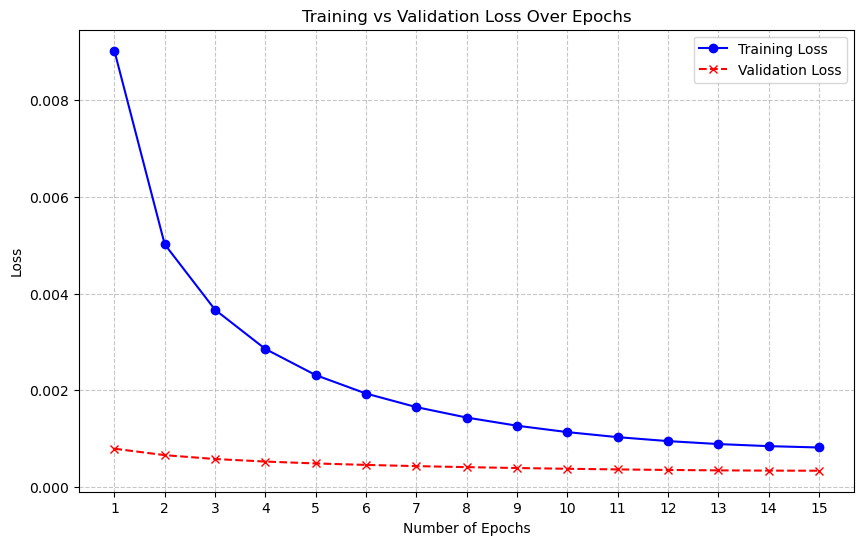



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.99 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004805).  Saving model ...
Epoch 10/150, Training Loss: 0.010419, Validation Loss: 0.000682
Validation loss decreased (0.004805 --> 0.003351).  Saving model ...
Epoch 20/150, Training Loss: 0.005654, Validation Loss: 0.000608
Validation loss decreased (0.003351 --> 0.002828).  Saving model ...
Epoch 30/150, Training Loss: 0.004086, Validation Loss: 0.000563
Validation loss decreased (0.002828 --> 0.002502).  Saving model ...
Epoch 40/150, Training Loss: 0.003173, Validation Loss: 0.000527
Validation loss decreased (0.002502 --> 0.002268).  Saving model ...
Epoch 50/150, Training Loss: 0.002579, Va

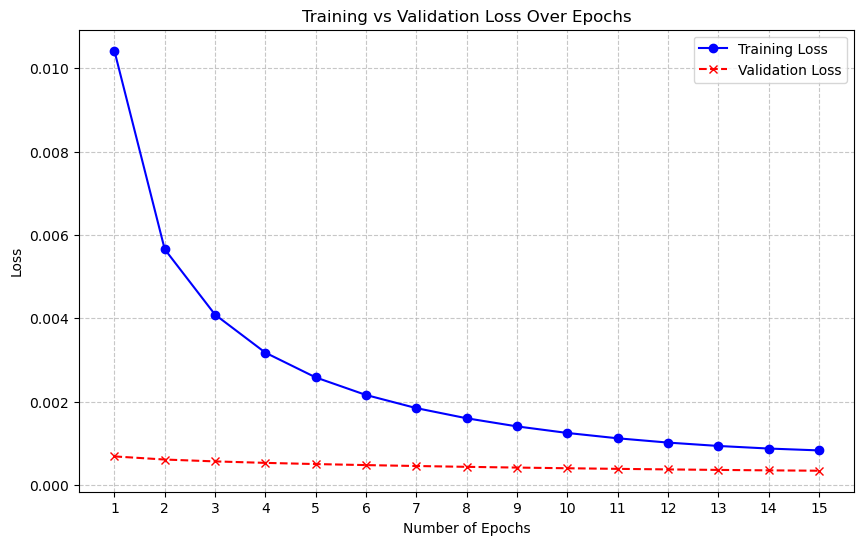



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  1 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.005526).  Saving model ...
Epoch 10/150, Training Loss: 0.012420, Validation Loss: 0.001199
Validation loss decreased (0.005526 --> 0.003565).  Saving model ...
Epoch 20/150, Training Loss: 0.006304, Validation Loss: 0.000776
Validation loss decreased (0.003565 --> 0.002900).  Saving model ...
Epoch 30/150, Training Loss: 0.004357, Validation Loss: 0.000626
Validation loss decreased (0.002900 --> 0.002519).  Saving model ...
Epoch 40/150, Training Loss: 0.003298, Validation Loss: 0.000548
Validation loss decreased (0.002519 --> 0.002257).  Saving model ...
Epoch 50/150, Training Loss: 0.002625, Valid

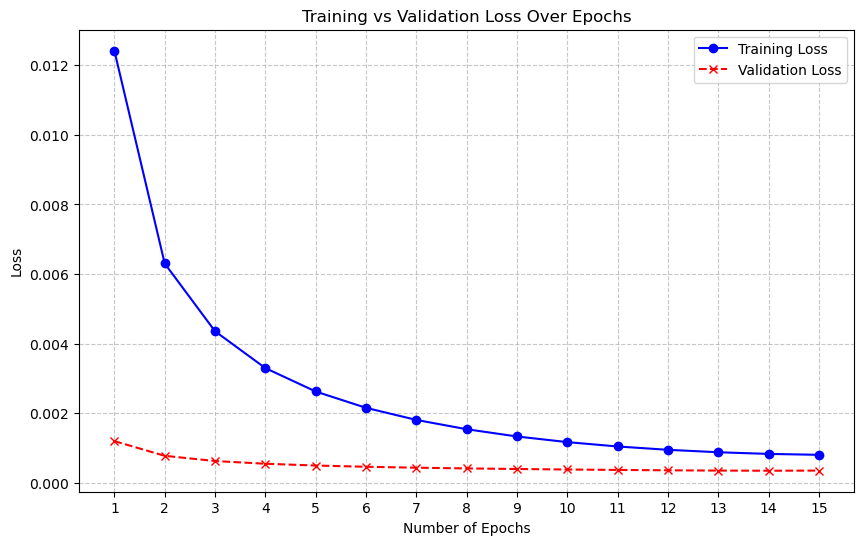



Best beta1:  0.99    Loss:  tensor(1.3832e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best beta1:  1    Loss:  tensor(1.3990e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [15]:
skip_this_step = False

if not skip_this_step:
    #test various learning rates
    beta1_list = [0.45, 0.7, 0.9, 0.95, 0.99, 1]
    best_beta1 = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_beta1_in_loop = np.inf
    repeated_loops_per_beta1 = 1
    bestRNN_b1_Setup = [rnnControlSetup,None]
    bestRNN_b1 = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for b1 in beta1_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_beta1)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", b1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len, 
                batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, 
                lr_scheduler_rate=lr_scheduler_rate, beta1=b1, beta2=beta2)
        for i in range(repeated_loops_per_beta1):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_beta1_in_loop > loss:
                best_beta1_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_beta1_in_loop < best_beta1[0][0]:
            best_beta1[1] = best_beta1[0]
            best_beta1[0] = [best_beta1_in_loop, b1]
            bestRNN_b1[1] = bestRNN_b1[0]
            bestRNN_b1[0] = bestRNN_in_loop
            bestRNN_b1_Setup[1] =  bestRNN_b1_Setup[0] 
            bestRNN_b1_Setup[0] =  rnnSetup
            #if 
        elif best_beta1_in_loop < best_beta1[1][0]:
            best_beta1[1] = [best_beta1_in_loop, b1]
            bestRNN_b1[1] = bestRNN_in_loop
            bestRNN_b1_Setup[1] =  rnnSetup
        best_beta1_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest beta1: ", best_beta1[0][1], "   Loss: ", best_beta1[0][0])
    print("Second best beta1: ", best_beta1[1][1], "   Loss: ", best_beta1[1][0])



# Test beta2 value effect



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.5
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.003511).  Saving model ...
Epoch 10/150, Training Loss: 0.005998, Validation Loss: 0.000653
Validation loss decreased (0.003511 --> 0.002848).  Saving model ...
Epoch 20/150, Training Loss: 0.003653, Validation Loss: 0.000594
Validation loss decreased (0.002848 --> 0.002537).  Saving model ...
Epoch 30/150, Training Loss: 0.002835, Validation Loss: 0.000546
Validation loss decreased (0.002537 --> 0.002310).  Saving model ...
Epoch 40/150, Training Loss: 0.002314, Validation Loss: 0.000509
Validation loss decreased (0.002310 --> 0.002126).  Saving model ...
Epoch 50/150, Training Loss: 0.001947, Valid

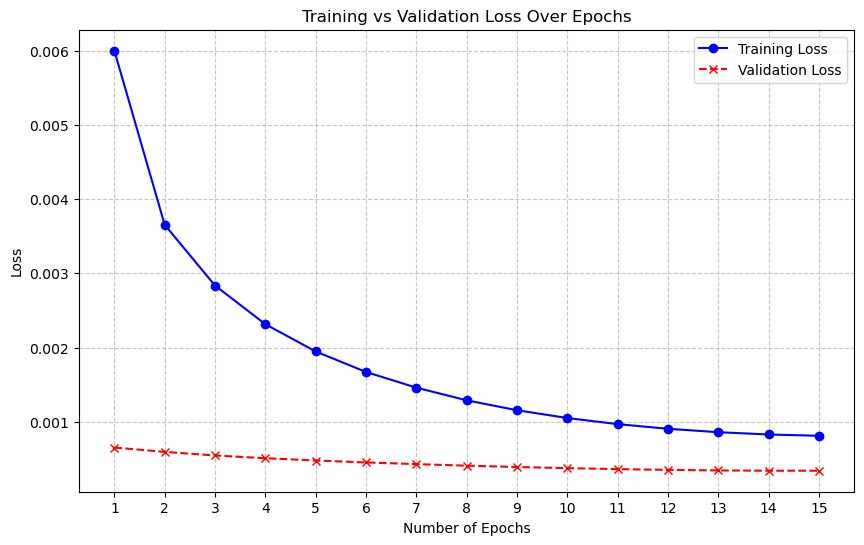



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.9
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.003582).  Saving model ...
Epoch 10/150, Training Loss: 0.006711, Validation Loss: 0.000648
Validation loss decreased (0.003582 --> 0.002711).  Saving model ...
Epoch 20/150, Training Loss: 0.003710, Validation Loss: 0.000553
Validation loss decreased (0.002711 --> 0.002374).  Saving model ...
Epoch 30/150, Training Loss: 0.002767, Validation Loss: 0.000506
Validation loss decreased (0.002374 --> 0.002146).  Saving model ...
Epoch 40/150, Training Loss: 0.002200, Validation Loss: 0.000472
Validation loss decreased (0.002146 --> 0.001972).  Saving model ...
Epoch 50/150, Training Loss: 0.001822, Valid

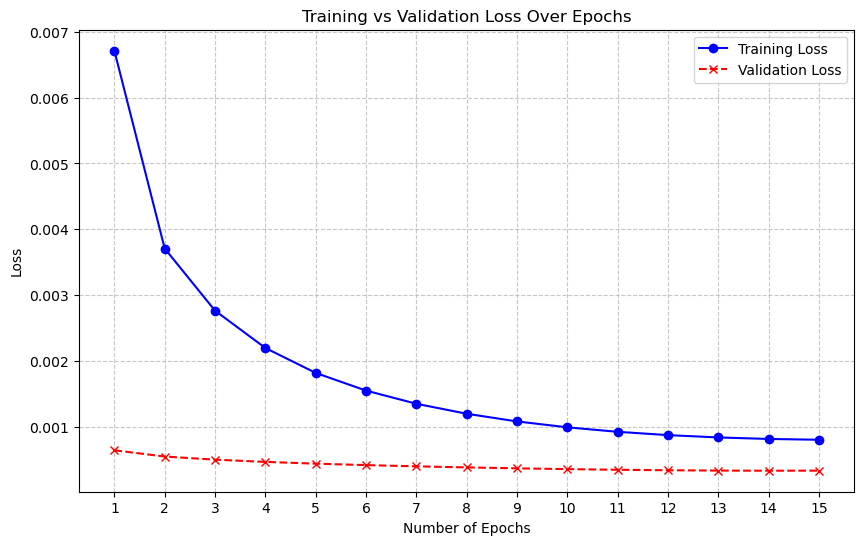



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.99
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004223).  Saving model ...
Epoch 10/150, Training Loss: 0.008572, Validation Loss: 0.000763
Validation loss decreased (0.004223 --> 0.003147).  Saving model ...
Epoch 20/150, Training Loss: 0.004837, Validation Loss: 0.000647
Validation loss decreased (0.003147 --> 0.002733).  Saving model ...
Epoch 30/150, Training Loss: 0.003643, Validation Loss: 0.000573
Validation loss decreased (0.002733 --> 0.002457).  Saving model ...
Epoch 40/150, Training Loss: 0.002908, Validation Loss: 0.000525
Validation loss decreased (0.002457 --> 0.002245).  Saving model ...
Epoch 50/150, Training Loss: 0.002397, Vali

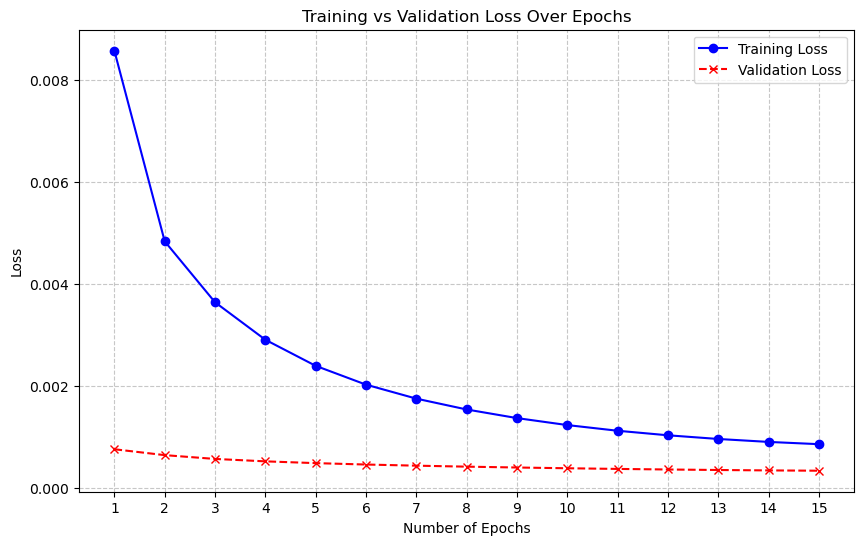



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004071).  Saving model ...
Epoch 10/150, Training Loss: 0.008026, Validation Loss: 0.000767
Validation loss decreased (0.004071 --> 0.002958).  Saving model ...
Epoch 20/150, Training Loss: 0.004277, Validation Loss: 0.000614
Validation loss decreased (0.002958 --> 0.002551).  Saving model ...
Epoch 30/150, Training Loss: 0.003110, Validation Loss: 0.000550
Validation loss decreased (0.002551 --> 0.002287).  Saving model ...
Epoch 40/150, Training Loss: 0.002423, Validation Loss: 0.000506
Validation loss decreased (0.002287 --> 0.002092).  Saving model ...
Epoch 50/150, Training Loss: 0.001982, Val

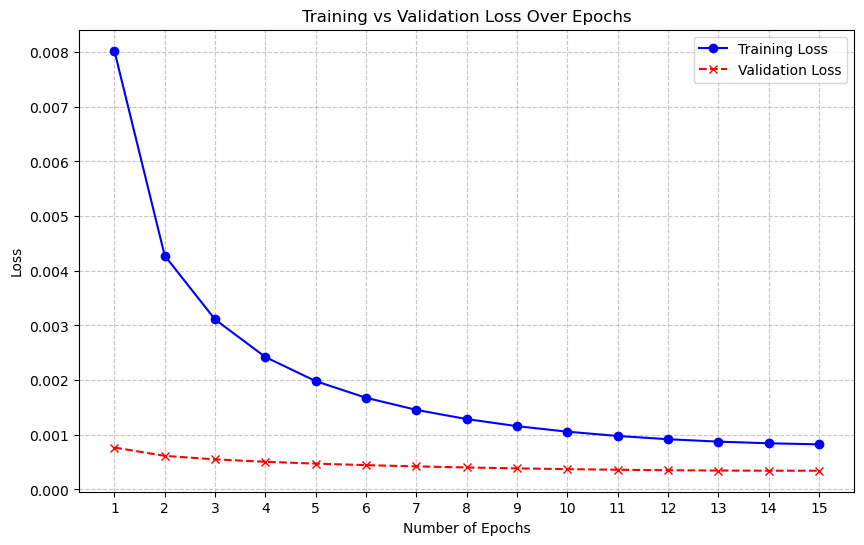



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.9999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.003858).  Saving model ...
Epoch 10/150, Training Loss: 0.007597, Validation Loss: 0.000642
Validation loss decreased (0.003858 --> 0.002790).  Saving model ...
Epoch 20/150, Training Loss: 0.003979, Validation Loss: 0.000554
Validation loss decreased (0.002790 --> 0.002394).  Saving model ...
Epoch 30/150, Training Loss: 0.002852, Validation Loss: 0.000509
Validation loss decreased (0.002394 --> 0.002142).  Saving model ...
Epoch 40/150, Training Loss: 0.002228, Validation Loss: 0.000476
Validation loss decreased (0.002142 --> 0.001953).  Saving model ...
Epoch 50/150, Training Loss: 0.001831, Va

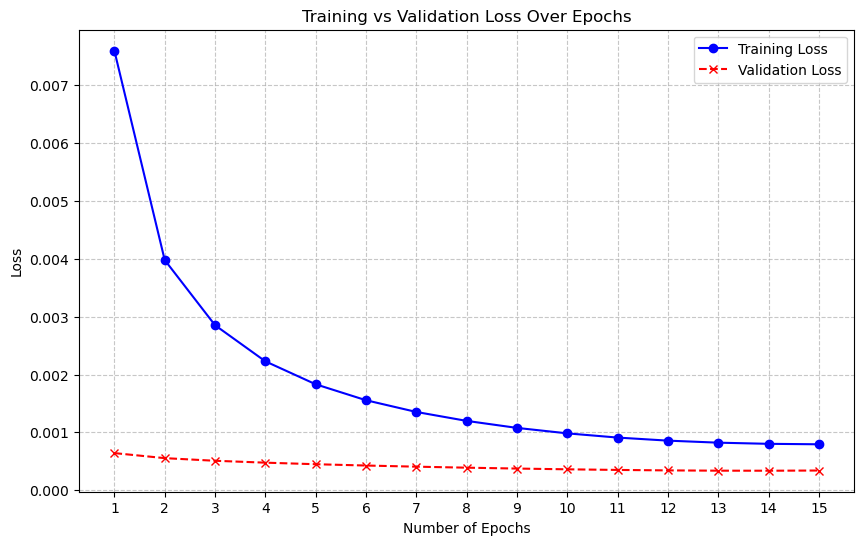



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  1
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004152).  Saving model ...
Epoch 10/150, Training Loss: 0.008587, Validation Loss: 0.000794
Validation loss decreased (0.004152 --> 0.002933).  Saving model ...
Epoch 20/150, Training Loss: 0.004538, Validation Loss: 0.000602
Validation loss decreased (0.002933 --> 0.002494).  Saving model ...
Epoch 30/150, Training Loss: 0.003204, Validation Loss: 0.000536
Validation loss decreased (0.002494 --> 0.002221).  Saving model ...
Epoch 40/150, Training Loss: 0.002458, Validation Loss: 0.000493
Validation loss decreased (0.002221 --> 0.002023).  Saving model ...
Epoch 50/150, Training Loss: 0.001988, Validat

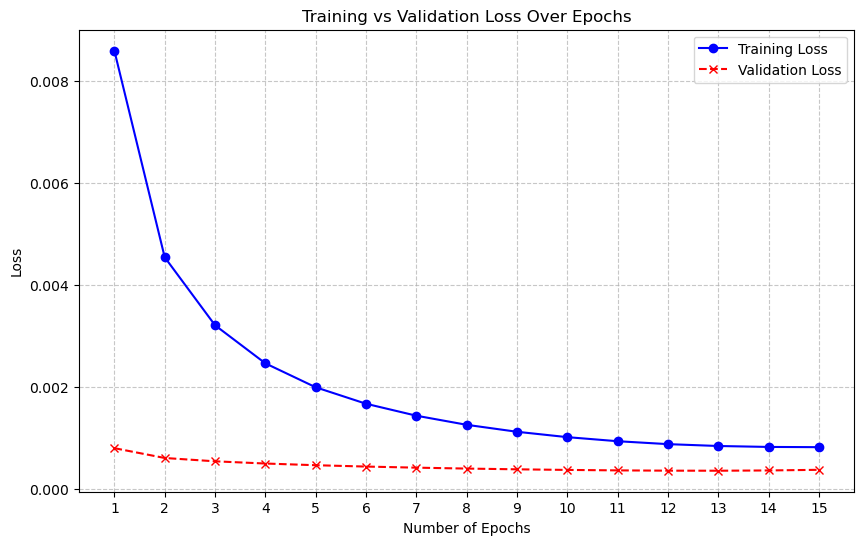



Best beta2:  0.9999    Loss:  tensor(1.4224e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best beta2:  0.5    Loss:  tensor(1.4289e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [16]:
skip_this_step = False
if not skip_this_step:
    #test various learning rates
    beta2_list = [0.5, 0.9, 0.99, 0.999, 0.9999, 1]
    best_beta2 = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_beta2_in_loop = np.inf
    repeated_loops_per_beta2 = 1
    bestRNN_b2_Setup = [rnnControlSetup,None]
    bestRNN_b2 = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for b2 in beta2_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_beta2)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", b2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len,
                    batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, 
                    lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=b2)
        for i in range(repeated_loops_per_beta2):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_beta2_in_loop > loss:
                best_beta2_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_beta2_in_loop < best_beta2[0][0]:
            best_beta2[1] = best_beta2[0]
            best_beta2[0] = [best_beta2_in_loop, b2]
            bestRNN_b2[1] = bestRNN_b2[0]
            bestRNN_b2[0] = bestRNN_in_loop
            bestRNN_b2_Setup[1] =  bestRNN_b2_Setup[0] 
            bestRNN_b2_Setup[0] =  rnnSetup
            #if 
        elif best_beta2_in_loop < best_beta2[1][0]:
            best_beta2[1] = [best_beta2_in_loop, b2]
            bestRNN_b2[1] = bestRNN_in_loop
            bestRNN_b2_Setup[1] =  rnnSetup
        best_beta2_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest beta2: ", best_beta2[0][1], "   Loss: ", best_beta2[0][0])
    print("Second best beta2: ", best_beta2[1][1], "   Loss: ", best_beta2[1][0])

# Test epochs



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  100
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.005773).  Saving model ...
Epoch 10/150, Training Loss: 0.013215, Validation Loss: 0.000920
Validation loss decreased (0.005773 --> 0.003633).  Saving model ...
Epoch 20/150, Training Loss: 0.006546, Validation Loss: 0.000644
Validation loss decreased (0.003633 --> 0.002934).  Saving model ...
Epoch 30/150, Training Loss: 0.004451, Validation Loss: 0.000563
Validation loss decreased (0.002934 --> 0.002541).  Saving model ...
Epoch 40/150, Training Loss: 0.003325, Validation Loss: 0.000518
Validation loss decreased (0.002541 --> 0.002275).  Saving model ...
Epoch 50/150, Training Loss: 0.002616, Val

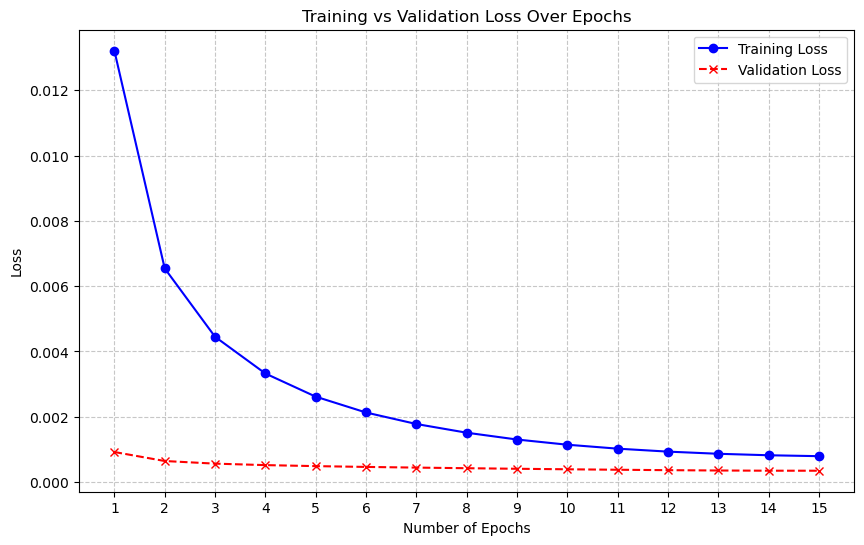



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.005600).  Saving model ...
Epoch 10/150, Training Loss: 0.011856, Validation Loss: 0.001415
Validation loss decreased (0.005600 --> 0.003779).  Saving model ...
Epoch 20/150, Training Loss: 0.006434, Validation Loss: 0.000852
Validation loss decreased (0.003779 --> 0.003152).  Saving model ...
Epoch 30/150, Training Loss: 0.004689, Validation Loss: 0.000687
Validation loss decreased (0.003152 --> 0.002760).  Saving model ...
Epoch 40/150, Training Loss: 0.003649, Validation Loss: 0.000594
Validation loss decreased (0.002760 --> 0.002477).  Saving model ...
Epoch 50/150, Training Loss: 0.002945, Val

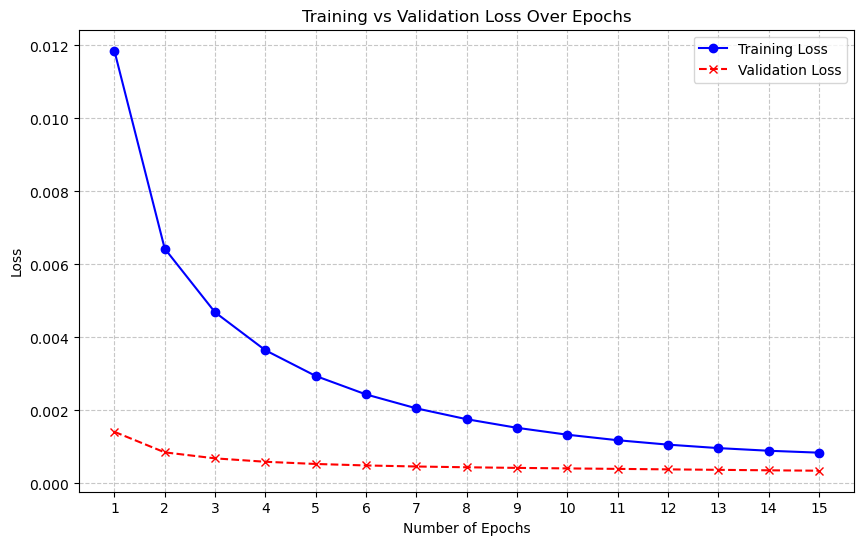



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  200
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004025).  Saving model ...
Epoch 10/150, Training Loss: 0.008401, Validation Loss: 0.000654
Validation loss decreased (0.004025 --> 0.003001).  Saving model ...
Epoch 20/150, Training Loss: 0.004858, Validation Loss: 0.000575
Validation loss decreased (0.003001 --> 0.002604).  Saving model ...
Epoch 30/150, Training Loss: 0.003628, Validation Loss: 0.000531
Validation loss decreased (0.002604 --> 0.002344).  Saving model ...
Epoch 40/150, Training Loss: 0.002874, Validation Loss: 0.000501
Validation loss decreased (0.002344 --> 0.002150).  Saving model ...
Epoch 50/150, Training Loss: 0.002365, Val

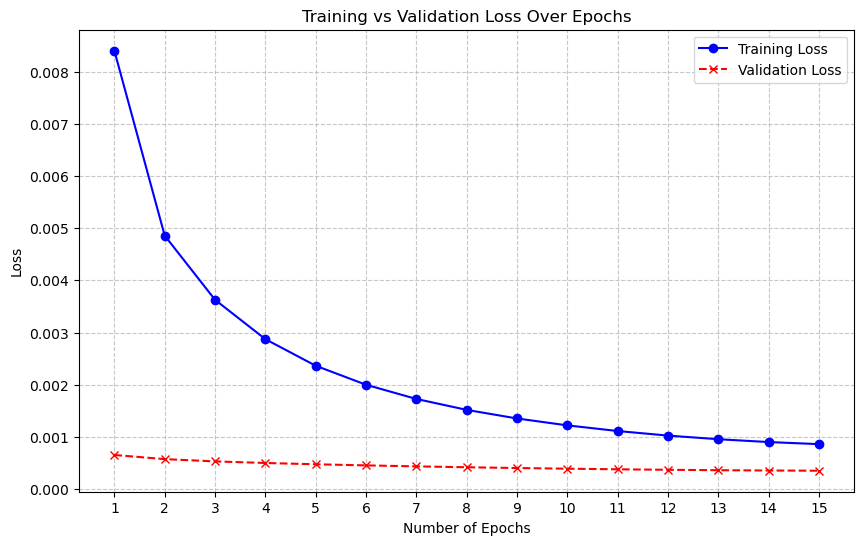



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  300
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004224).  Saving model ...
Epoch 10/150, Training Loss: 0.008433, Validation Loss: 0.000782
Validation loss decreased (0.004224 --> 0.002903).  Saving model ...
Epoch 20/150, Training Loss: 0.004142, Validation Loss: 0.000595
Validation loss decreased (0.002903 --> 0.002434).  Saving model ...
Epoch 30/150, Training Loss: 0.002906, Validation Loss: 0.000517
Validation loss decreased (0.002434 --> 0.002139).  Saving model ...
Epoch 40/150, Training Loss: 0.002228, Validation Loss: 0.000467
Validation loss decreased (0.002139 --> 0.001926).  Saving model ...
Epoch 50/150, Training Loss: 0.001798, Val

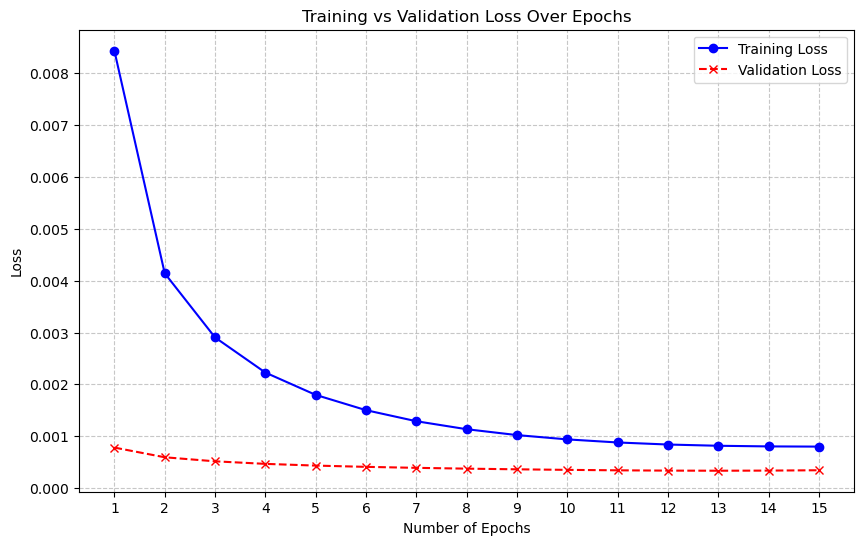



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  400
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004153).  Saving model ...
Epoch 10/150, Training Loss: 0.008723, Validation Loss: 0.000662
Validation loss decreased (0.004153 --> 0.003059).  Saving model ...
Epoch 20/150, Training Loss: 0.004842, Validation Loss: 0.000603
Validation loss decreased (0.003059 --> 0.002663).  Saving model ...
Epoch 30/150, Training Loss: 0.003579, Validation Loss: 0.000558
Validation loss decreased (0.002663 --> 0.002407).  Saving model ...
Epoch 40/150, Training Loss: 0.002848, Validation Loss: 0.000522
Validation loss decreased (0.002407 --> 0.002214).  Saving model ...
Epoch 50/150, Training Loss: 0.002364, Val

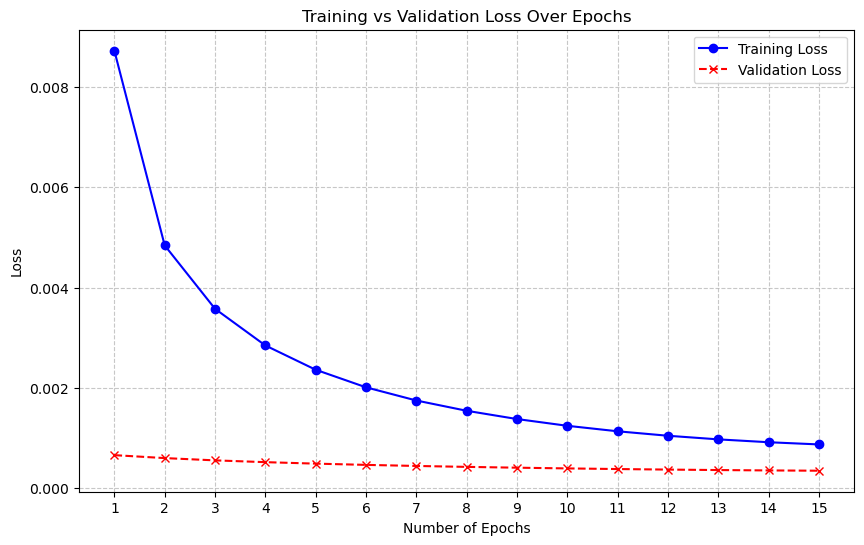



Best learning rate:  150    Loss:  tensor(1.3407e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best learning rate:  100    Loss:  tensor(1.3499e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [17]:
skip_this_step = False

if not skip_this_step:
    #test various learning rates
    epoch_list = [100, 150, 200, 300, 400] #revert later for hyperparameter testing, the first few values are not good current set of hyperparameters
    #learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
    best_epoch = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_epoch_in_loop = np.inf
    repeated_loops_per_epoch = 1
    bestRNN_ep_Setup = [rnnControlSetup,None]
    bestRNN_ep = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for ep in epoch_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_epoch)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", ep)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], sequence_len=sequence_len,
                    batch_size=batch_size, num_workers=num_workers, epochs=ep, learning_rate=lr, 
                    lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_epoch):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_epoch_in_loop > loss:
                best_epoch_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_epoch_in_loop < best_epoch[0][0]:
            best_epoch[1] = best_epoch[0]
            best_epoch[0] = [best_epoch_in_loop, ep]
            bestRNN_ep[1] = bestRNN_ep[0]
            bestRNN_ep[0] = bestRNN_in_loop
            bestRNN_ep_Setup[1] =  bestRNN_ep_Setup[0] 
            bestRNN_ep_Setup[0] =  rnnSetup
            #if 
        elif best_epoch_in_loop < best_epoch[1][0]:
            best_epoch[1] = [best_lr_in_loop, ep]
            bestRNN_ep[1] = bestRNN_in_loop
            bestRNN_ep_Setup[1] =  rnnSetup
        best_epoch_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest learning rate: ", best_epoch[0][1], "   Loss: ", best_epoch[0][0])
    print("Second best learning rate: ", best_epoch[1][1], "   Loss: ", best_epoch[1][0])


# test batch_size

# test sequence_size



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
Sequence size:  2
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.002337).  Saving model ...
Epoch 10/150, Training Loss: 0.004285, Validation Loss: 0.000272
Validation loss decreased (0.002337 --> 0.001852).  Saving model ...
Epoch 20/150, Training Loss: 0.002517, Validation Loss: 0.000248
Validation loss decreased (0.001852 --> 0.001744).  Saving model ...
Epoch 30/150, Training Loss: 0.002187, Validation Loss: 0.000217
Validation loss decreased (0.001744 --> 0.001670).  Saving model ...
Epoch 40/150, Training Loss: 0.001972, Validation Loss: 0.000198
Validation loss decreased (0.001670 --> 0.001611).  Saving model ...
Epoch 50/150, Training L

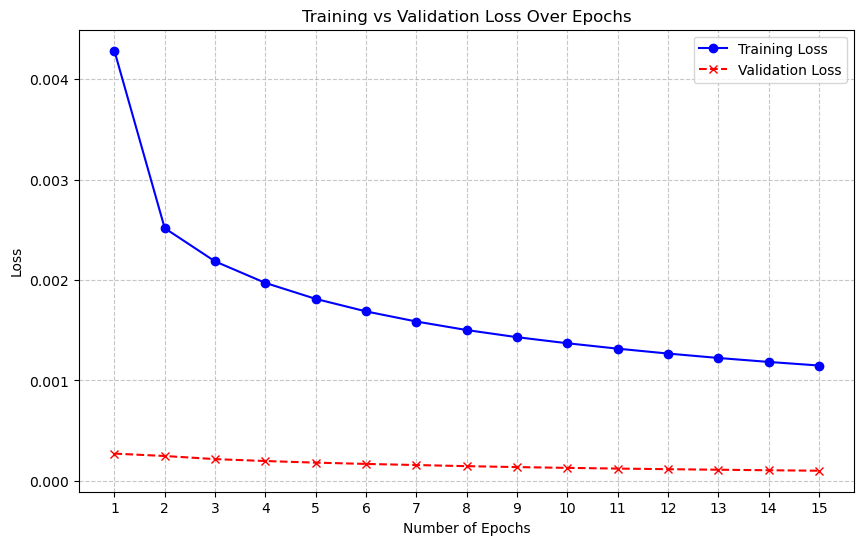



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
Sequence size:  4
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.003929).  Saving model ...
Epoch 10/150, Training Loss: 0.007661, Validation Loss: 0.000727
Validation loss decreased (0.003929 --> 0.003017).  Saving model ...
Epoch 20/150, Training Loss: 0.004377, Validation Loss: 0.000637
Validation loss decreased (0.003017 --> 0.002652).  Saving model ...
Epoch 30/150, Training Loss: 0.003320, Validation Loss: 0.000571
Validation loss decreased (0.002652 --> 0.002406).  Saving model ...
Epoch 40/150, Training Loss: 0.002686, Validation Loss: 0.000526
Validation loss decreased (0.002406 --> 0.002218).  Saving model ...
Epoch 50/150, Training L

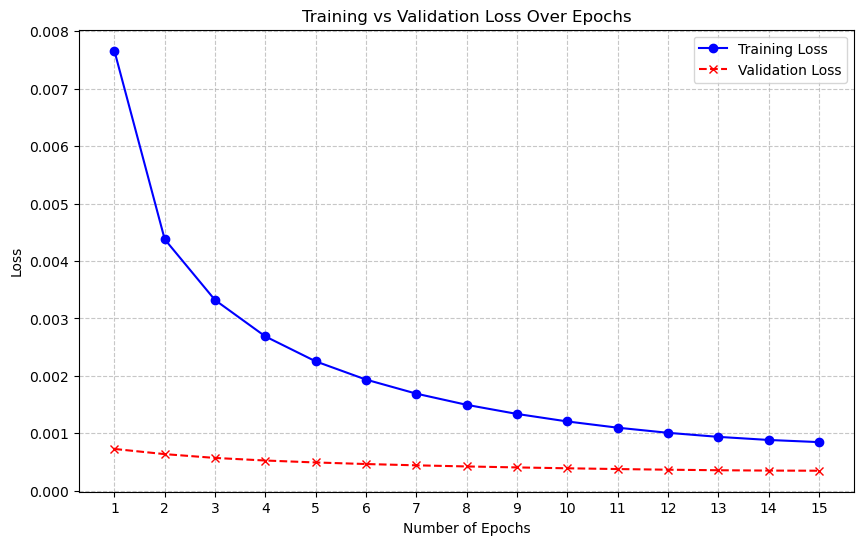



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
Sequence size:  6
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.006827).  Saving model ...
Epoch 10/150, Training Loss: 0.016668, Validation Loss: 0.000920
Validation loss decreased (0.006827 --> 0.004148).  Saving model ...
Epoch 20/150, Training Loss: 0.008310, Validation Loss: 0.000607
Validation loss decreased (0.004148 --> 0.003127).  Saving model ...
Epoch 30/150, Training Loss: 0.005179, Validation Loss: 0.000482
Validation loss decreased (0.003127 --> 0.002537).  Saving model ...
Epoch 40/150, Training Loss: 0.003499, Validation Loss: 0.000403
Validation loss decreased (0.002537 --> 0.002139).  Saving model ...
Epoch 50/150, Training L

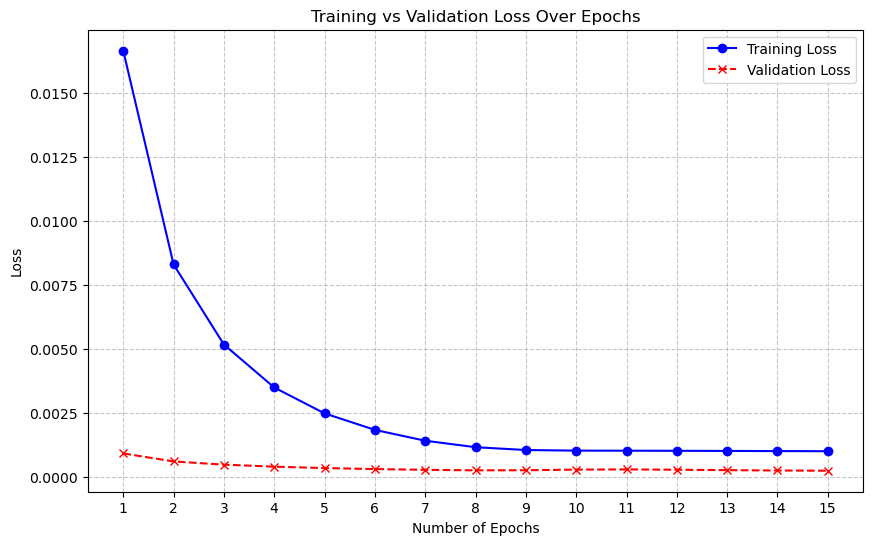



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
Sequence size:  8
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.008270).  Saving model ...
Epoch 10/150, Training Loss: 0.023133, Validation Loss: 0.000894
Validation loss decreased (0.008270 --> 0.004105).  Saving model ...
Epoch 20/150, Training Loss: 0.009210, Validation Loss: 0.000629
Validation loss decreased (0.004105 --> 0.002716).  Saving model ...
Epoch 30/150, Training Loss: 0.004556, Validation Loss: 0.000480
Validation loss decreased (0.002716 --> 0.002047).  Saving model ...
Epoch 40/150, Training Loss: 0.002563, Validation Loss: 0.000398
Validation loss decreased (0.002047 --> 0.001696).  Saving model ...
Epoch 50/150, Training L

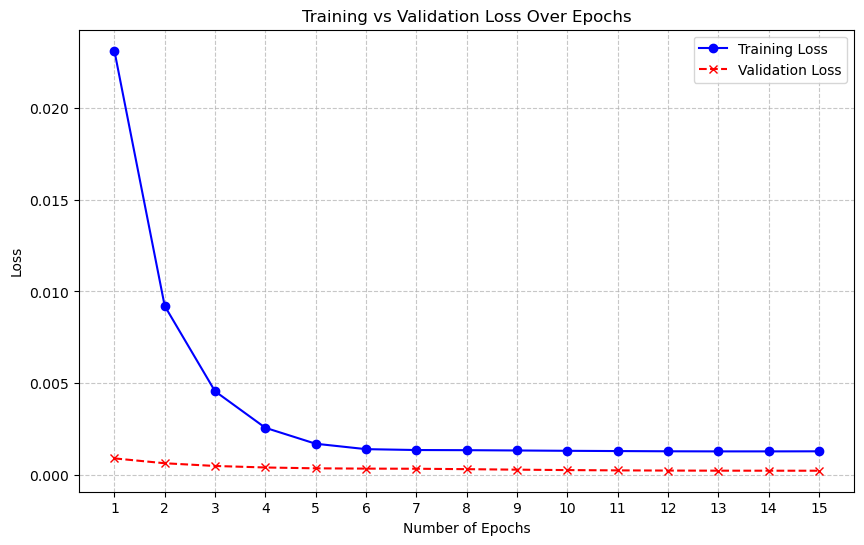



-------------------------------------------------------------------------------
Learning rate:  0.001    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
Sequence size:  10
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.013394).  Saving model ...
Epoch 10/150, Training Loss: 0.036475, Validation Loss: 0.001162
Validation loss decreased (0.013394 --> 0.005176).  Saving model ...
Epoch 20/150, Training Loss: 0.012112, Validation Loss: 0.000798
Validation loss decreased (0.005176 --> 0.002829).  Saving model ...
Epoch 30/150, Training Loss: 0.004454, Validation Loss: 0.000539
Validation loss decreased (0.002829 --> 0.002000).  Saving model ...
Epoch 40/150, Training Loss: 0.002062, Validation Loss: 0.000391
Validation loss decreased (0.002000 --> 0.001709).  Saving model ...
Epoch 50/150, Training 

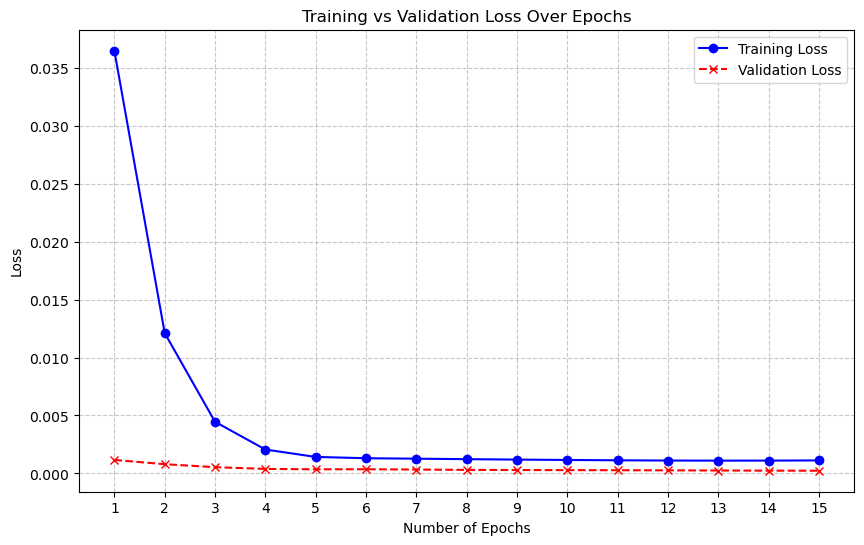



Best learning rate:  150    Loss:  tensor(1.3407e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best learning rate:  100    Loss:  tensor(1.3499e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [18]:
skip_this_step = False
#NOTE this is not working, and will not work properly unless we optimize the RNN_initializer
if not skip_this_step:
    #test various learning rates
    seq_list = [2, 4, 6, 8, 10] #revert later for hyperparameter testing, the first few values are not good current set of hyperparameters
    #learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
    best_seq = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_seq_in_loop = np.inf
    repeated_loops_per_seq = 1
    bestRNN_seq_Setup = [rnnControlSetup,None]
    bestRNN_seq = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for seq in seq_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_epoch)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("Sequence size: ", seq)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], 
                    batch_size=batch_size, sequence_len=seq, num_workers=num_workers, epochs=epochs, learning_rate=lr, 
                    lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_seq):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_epoch_in_loop > loss:
                best_epoch_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_epoch_in_loop < best_epoch[0][0]:
            best_seq[1] = best_seq[0]
            best_seq[0] = [best_seq_in_loop, lr]
            bestRNN_seq[1] = bestRNN_seq[0]
            bestRNN_seq[0] = bestRNN_in_loop
            bestRNN_seq_Setup[1] =  bestRNN_seq_Setup[0] 
            bestRNN_seq_Setup[0] =  rnnSetup
            #if 
        elif best_epoch_in_loop < best_epoch[1][0]:
            best_epoch[1] = [best_lr_in_loop, epoch]
            bestRNN_seq[1] = bestRNN_in_loop
            bestRNN_seq_Setup[1] =  rnnSetup
        best_epoch_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest learning rate: ", best_epoch[0][1], "   Loss: ", best_epoch[0][0])
    print("Second best learning rate: ", best_epoch[1][1], "   Loss: ", best_epoch[1][0])


# test scheduler_rate

In [19]:
skip_this_step = True
#NOTE this is not working, and will not work properly unless we optimize the RNN_initializer
if not skip_this_step:
    #test various learning rates
    seq_list = [2, 4, 6, 8, 10] #revert later for hyperparameter testing, the first few values are not good current set of hyperparameters
    #learning_rate_list = [0.0005, 0.0001, 0.00005, 0.00001]
    best_seq = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_seq_in_loop = np.inf
    repeated_loops_per_seq = 1
    bestRNN_bs_Setup = [rnnControlSetup,None]
    bestRNN = [rnnControl,None]
    bestRNN_in_loop = rnnControl
    #lr testing
    for seq in seq_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", 0.001, "   Loop: ", repeated_loops_per_epoch)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("Sequence size: ", seq)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=False, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], 
                    batch_size=batch_size, sequence_len=seq, num_workers=num_workers, epochs=epochs, learning_rate=lr, 
                    lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_seq):
            rnn = rnnSetup.init_RNN()
            #returns
            training_loss_array = []
            validation_loss_array = []
            loss = rnnSetup.trainAndTest(rnn)
            if best_epoch_in_loop > loss:
                best_epoch_in_loop = loss
                bestRNN_in_loop = rnn
        #if found best lr, remove worst lr from list
        if best_epoch_in_loop < best_epoch[0][0]:
            best_epoch[1] = best_epoch[0]
            best_epoch[0] = [best_epoch_in_loop, lr]
            bestRNN[1] = bestRNN[0]
            bestRNN[0] = bestRNN_in_loop
            bestRNN_bs_Setup[1] =  bestRNN_bs_Setup[0] 
            bestRNN_bs_Setup[0] =  rnnSetup
            #if 
        elif best_epoch_in_loop < best_epoch[1][0]:
            best_epoch[1] = [best_lr_in_loop, epoch]
            bestRNN[1] = bestRNN_in_loop
            bestRNN_bs_Setup[1] =  rnnSetup
        best_epoch_in_loop = np.inf

        plot_loss(training_loss_array, validation_loss_array, epochs)

    print("\n\nBest learning rate: ", best_epoch[0][1], "   Loss: ", best_epoch[0][0])
    print("Second best learning rate: ", best_epoch[1][1], "   Loss: ", best_epoch[1][0])


# Cherry pick the good lr



-------------------------------------------------------------------------------
Learning rate:  1e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.004638).  Saving model ...
Epoch 10/150, Training Loss: 0.009655, Validation Loss: 0.000957
Validation loss decreased (0.004638 --> 0.003216).  Saving model ...
Epoch 20/150, Training Loss: 0.005170, Validation Loss: 0.000652
Validation loss decreased (0.003216 --> 0.002710).  Saving model ...
Epoch 30/150, Training Loss: 0.003719, Validation Loss: 0.000561
Validation loss decreased (0.002710 --> 0.002404).  Saving model ...
Epoch 40/150, Training Loss: 0.002891, Validation Loss: 0.000512
Validation loss decreased (0.002404 --> 0.002187).  Saving model ...
Epoch 50/150, Training Loss: 0.002357, Val

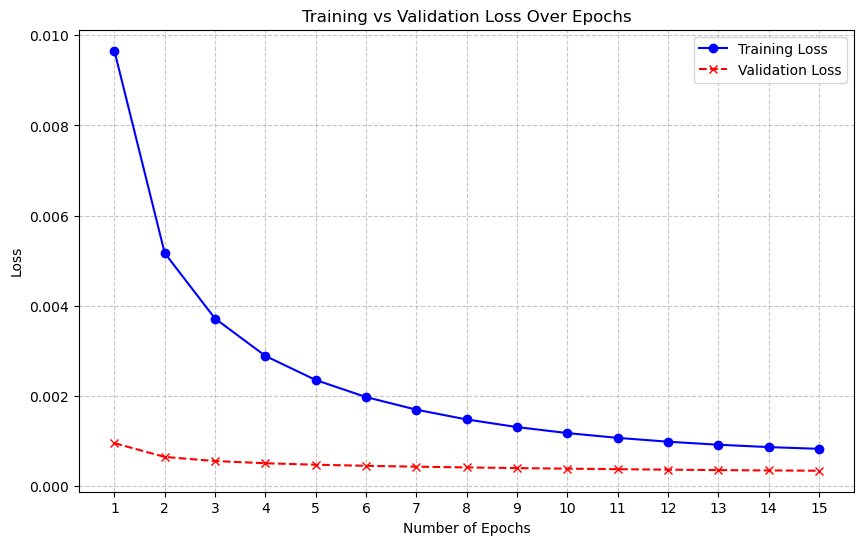



-------------------------------------------------------------------------------
Learning rate:  1.4000000000000001e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.003766).  Saving model ...
Epoch 10/150, Training Loss: 0.005996, Validation Loss: 0.000931
Validation loss decreased (0.003766 --> 0.002716).  Saving model ...
Epoch 20/150, Training Loss: 0.003085, Validation Loss: 0.000581
Validation loss decreased (0.002716 --> 0.002337).  Saving model ...
Epoch 30/150, Training Loss: 0.002205, Validation Loss: 0.000506
Validation loss decreased (0.002337 --> 0.002094).  Saving model ...
Epoch 40/150, Training Loss: 0.001735, Validation Loss: 0.000471
Validation loss decreased (0.002094 --> 0.001906).  Saving model ...
Epoch 50/150, Training Lo

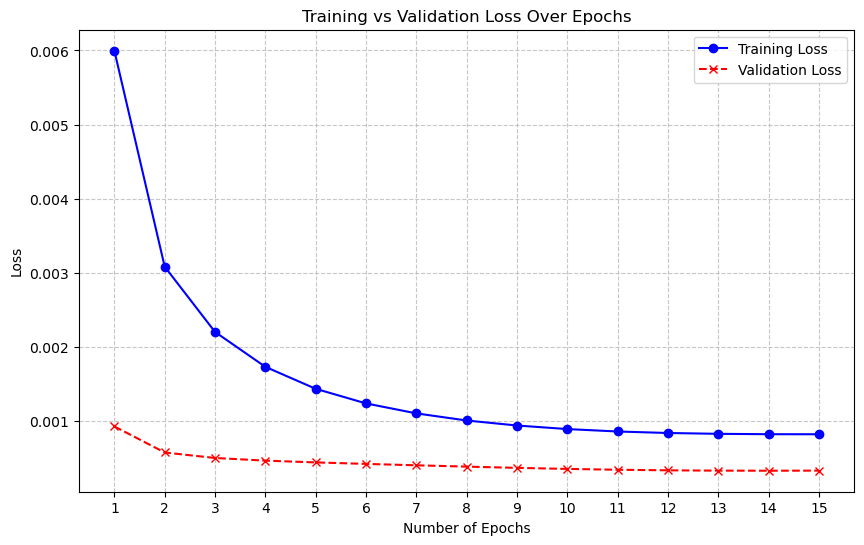



-------------------------------------------------------------------------------
Learning rate:  1.8000000000000004e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.002690).  Saving model ...
Epoch 10/150, Training Loss: 0.002768, Validation Loss: 0.000581
Validation loss decreased (0.002690 --> 0.002287).  Saving model ...
Epoch 20/150, Training Loss: 0.001837, Validation Loss: 0.000515
Validation loss decreased (0.002287 --> 0.002071).  Saving model ...
Epoch 30/150, Training Loss: 0.001516, Validation Loss: 0.000486
Validation loss decreased (0.002071 --> 0.001899).  Saving model ...
Epoch 40/150, Training Loss: 0.001326, Validation Loss: 0.000458
Validation loss decreased (0.001899 --> 0.001746).  Saving model ...
Epoch 50/150, Training Lo

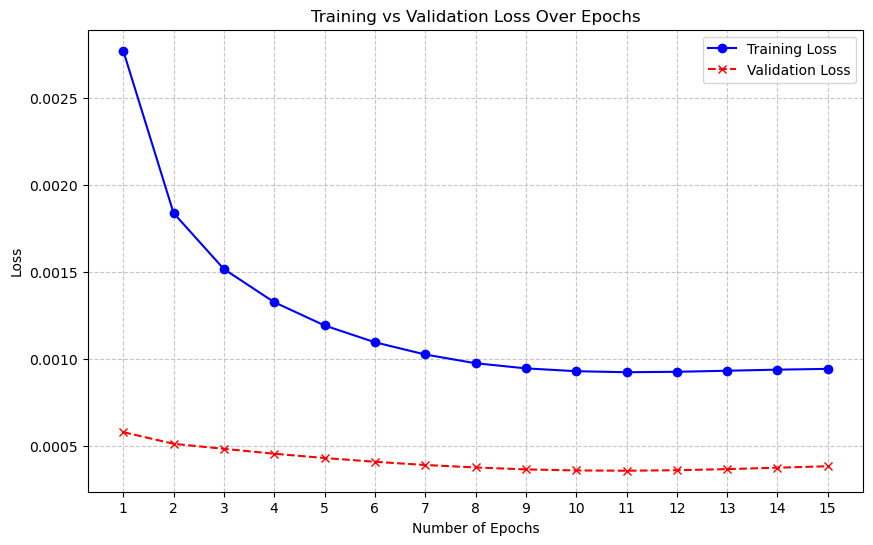



-------------------------------------------------------------------------------
Learning rate:  2.2000000000000003e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.002642).  Saving model ...
Epoch 10/150, Training Loss: 0.002184, Validation Loss: 0.000580
Validation loss decreased (0.002642 --> 0.002258).  Saving model ...
Epoch 20/150, Training Loss: 0.001641, Validation Loss: 0.000502
Validation loss decreased (0.002258 --> 0.002015).  Saving model ...
Epoch 30/150, Training Loss: 0.001445, Validation Loss: 0.000458
Validation loss decreased (0.002015 --> 0.001822).  Saving model ...
Epoch 40/150, Training Loss: 0.001337, Validation Loss: 0.000424
Validation loss decreased (0.001822 --> 0.001661).  Saving model ...
Epoch 50/150, Training Lo

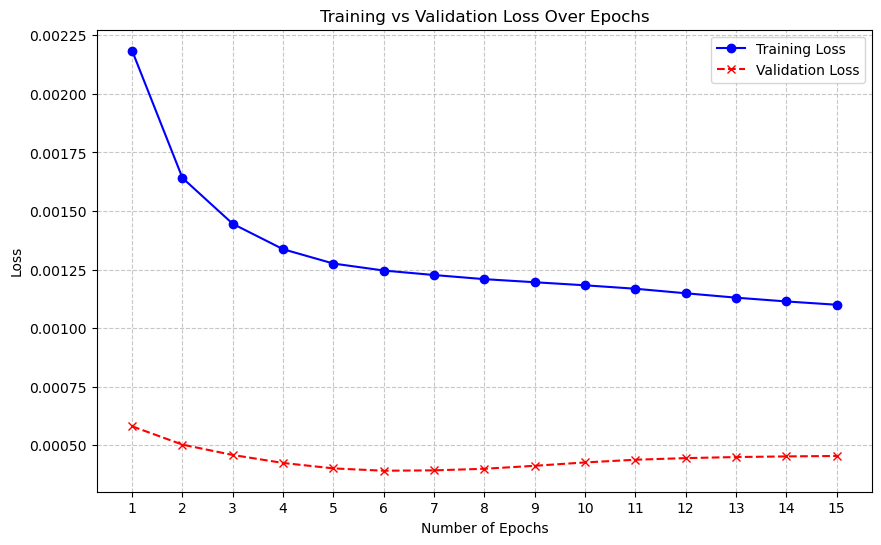



-------------------------------------------------------------------------------
Learning rate:  2.6000000000000002e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.002534).  Saving model ...
Epoch 10/150, Training Loss: 0.002074, Validation Loss: 0.000532
Validation loss decreased (0.002534 --> 0.002187).  Saving model ...
Epoch 20/150, Training Loss: 0.001610, Validation Loss: 0.000500
Validation loss decreased (0.002187 --> 0.001940).  Saving model ...
Epoch 30/150, Training Loss: 0.001432, Validation Loss: 0.000459
Validation loss decreased (0.001940 --> 0.001749).  Saving model ...
Epoch 40/150, Training Loss: 0.001341, Validation Loss: 0.000417
Validation loss decreased (0.001749 --> 0.001599).  Saving model ...
Epoch 50/150, Training Lo

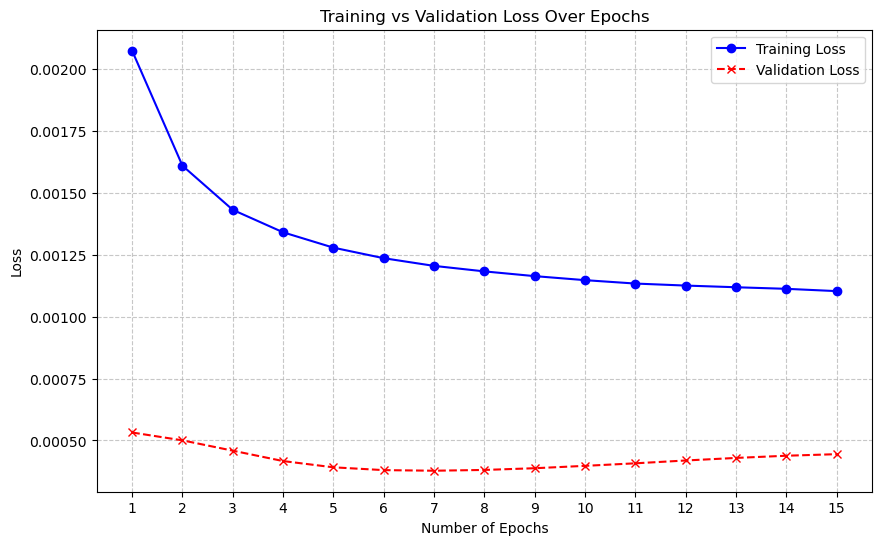



-------------------------------------------------------------------------------
Learning rate:  3.0000000000000004e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.002842).  Saving model ...
Epoch 10/150, Training Loss: 0.002373, Validation Loss: 0.000684
Validation loss decreased (0.002842 --> 0.002397).  Saving model ...
Epoch 20/150, Training Loss: 0.002012, Validation Loss: 0.000530
Validation loss decreased (0.002397 --> 0.002097).  Saving model ...
Epoch 30/150, Training Loss: 0.001820, Validation Loss: 0.000477
Validation loss decreased (0.002097 --> 0.001866).  Saving model ...
Epoch 40/150, Training Loss: 0.001719, Validation Loss: 0.000454
Validation loss decreased (0.001866 --> 0.001681).  Saving model ...
Epoch 50/150, Training Lo

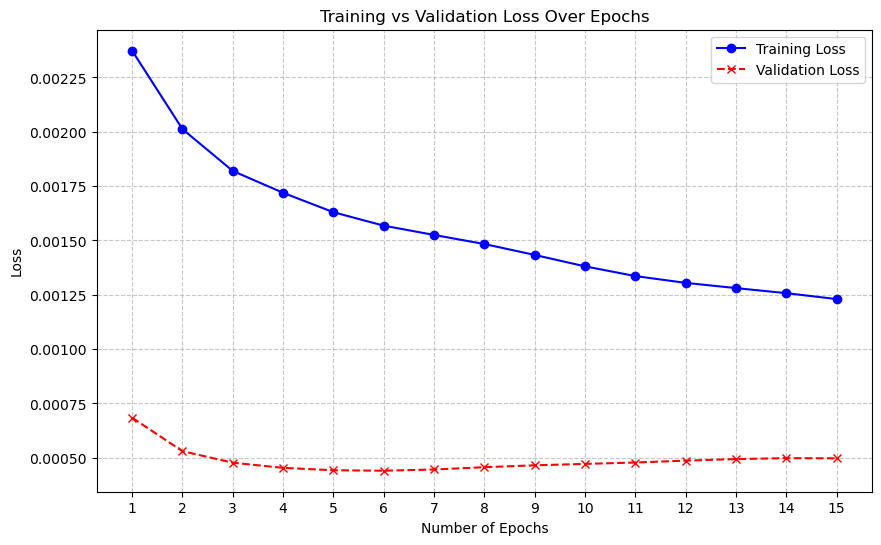



-------------------------------------------------------------------------------
Learning rate:  3.4000000000000007e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.002783).  Saving model ...
Epoch 10/150, Training Loss: 0.002376, Validation Loss: 0.000609
Validation loss decreased (0.002783 --> 0.002418).  Saving model ...
Epoch 20/150, Training Loss: 0.002021, Validation Loss: 0.000517
Validation loss decreased (0.002418 --> 0.002139).  Saving model ...
Epoch 30/150, Training Loss: 0.001811, Validation Loss: 0.000476
Validation loss decreased (0.002139 --> 0.001920).  Saving model ...
Epoch 40/150, Training Loss: 0.001706, Validation Loss: 0.000451
Validation loss decreased (0.001920 --> 0.001746).  Saving model ...
Epoch 50/150, Training Lo

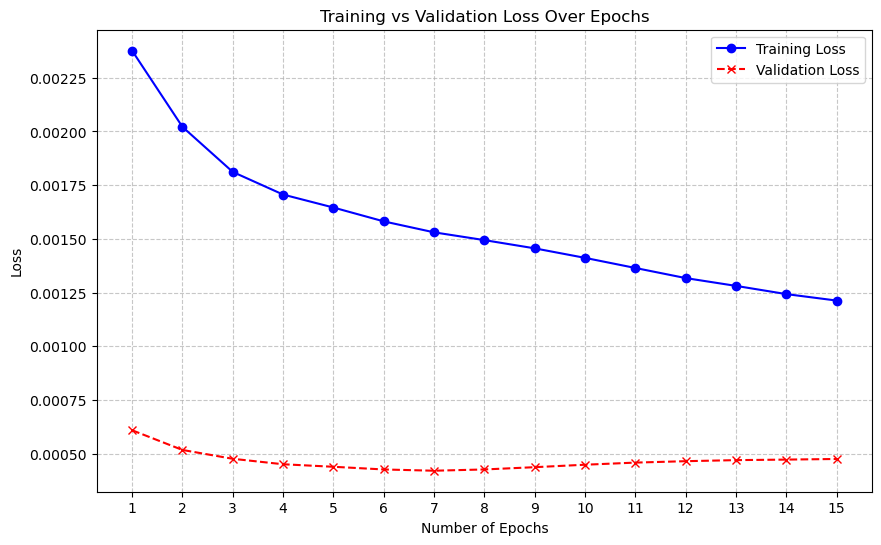



-------------------------------------------------------------------------------
Learning rate:  3.8e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.003116).  Saving model ...
Epoch 10/150, Training Loss: 0.003095, Validation Loss: 0.000901
Validation loss decreased (0.003116 --> 0.002499).  Saving model ...
Epoch 20/150, Training Loss: 0.002386, Validation Loss: 0.000547
Validation loss decreased (0.002499 --> 0.002172).  Saving model ...
Epoch 30/150, Training Loss: 0.002038, Validation Loss: 0.000471
Validation loss decreased (0.002172 --> 0.001928).  Saving model ...
Epoch 40/150, Training Loss: 0.001866, Validation Loss: 0.000437
Validation loss decreased (0.001928 --> 0.001731).  Saving model ...
Epoch 50/150, Training Loss: 0.001777, V

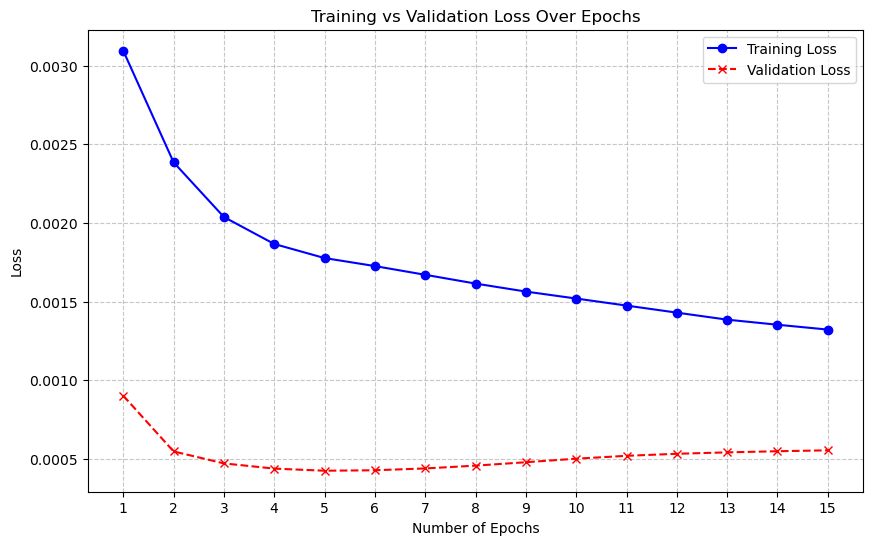



-------------------------------------------------------------------------------
Learning rate:  4.2000000000000004e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.003848).  Saving model ...
Epoch 10/150, Training Loss: 0.004031, Validation Loss: 0.001577
Validation loss decreased (0.003848 --> 0.002697).  Saving model ...
Epoch 20/150, Training Loss: 0.002675, Validation Loss: 0.000695
Validation loss decreased (0.002697 --> 0.002277).  Saving model ...
Epoch 30/150, Training Loss: 0.002253, Validation Loss: 0.000553
Validation loss decreased (0.002277 --> 0.002007).  Saving model ...
Epoch 40/150, Training Loss: 0.002093, Validation Loss: 0.000521
Validation loss decreased (0.002007 --> 0.001804).  Saving model ...
Epoch 50/150, Training Lo

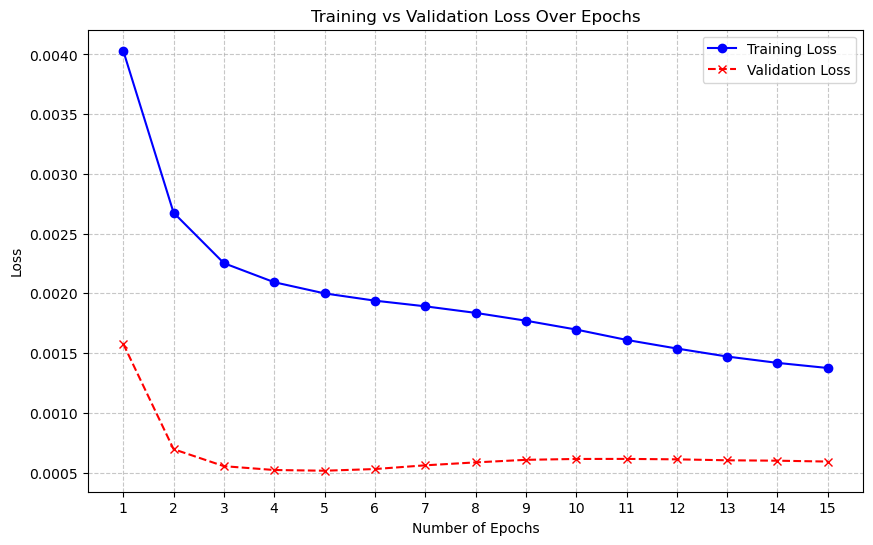



-------------------------------------------------------------------------------
Learning rate:  4.600000000000001e-05    Loop:  1
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.9 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.003743).  Saving model ...
Epoch 10/150, Training Loss: 0.003963, Validation Loss: 0.001376
Validation loss decreased (0.003743 --> 0.002625).  Saving model ...
Epoch 20/150, Training Loss: 0.002608, Validation Loss: 0.000535
Validation loss decreased (0.002625 --> 0.002265).  Saving model ...
Epoch 30/150, Training Loss: 0.002293, Validation Loss: 0.000484
Validation loss decreased (0.002265 --> 0.002005).  Saving model ...
Epoch 40/150, Training Loss: 0.002177, Validation Loss: 0.000465
Validation loss decreased (0.002005 --> 0.001824).  Saving model ...
Epoch 50/150, Training Los

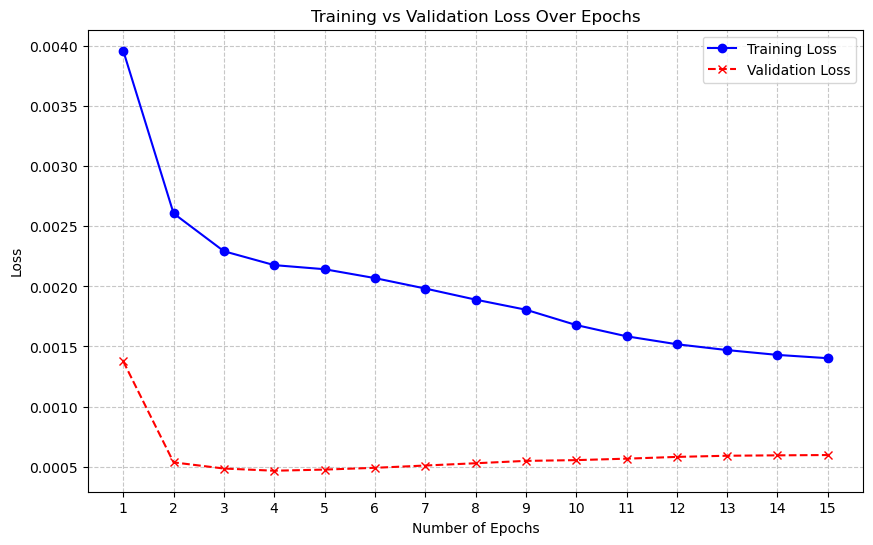



Best learning rate:  1e-05    Loss:  tensor(1.3939e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
Second best learning rate:  1e-05    Loss:  tensor(1.5402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [20]:
skip_this_step = False

if not skip_this_step:
    learning_rate_list = []
    difference_of_lr = best_lr[0][1] - best_lr[1][1]
    number_of_increments = 10
    increment = difference_of_lr / number_of_increments

    for i in range(number_of_increments):
        learning_rate_list.append(best_lr[0][1] - increment * i)

    for lr in learning_rate_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")

        
        rnnSetup = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"],sequence_len=sequence_len,
            batch_size=batch_size, num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_lr):
            training_loss_array = []
            validation_loss_array = []
            rnn = rnnSetup.init_RNN()
            loss = rnnSetup.trainAndTest(rnn)
            if best_lr_in_loop > loss:
                best_lr_in_loop = loss

        if best_lr_in_loop < best_lr[0][0]:
            best_lr[1] = best_lr[0]
            best_lr[0] = [best_lr_in_loop, lr]
        elif best_lr_in_loop < best_lr[1][0]:
            best_lr[1] = [best_lr_in_loop, lr]

        best_lr_in_loop = np.inf


        plot_loss(training_loss_array, validation_loss_array, epochs)


    print("\n\nBest learning rate: ", best_lr[0][1], "   Loss: ", best_lr[0][0])
    print("Second best learning rate: ", best_lr[1][1], "   Loss: ", best_lr[1][0])

skip_this_step = False

In [21]:
#Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="12" #months
    epochs = 150
    lr_scheduler_rate = 0.1
    beta1 = 0.90
    beta2 = 0.999

batch_size = 16
num_workers = 0



-------------------------------------------------------------------------------
Learning rate:  0.00018    Loop:  3
AMD Time interval  15 min Time period:  24 months
Batch size:  16 Number of workers:  0 Epochs:  200
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.072589).  Saving model ...
Epoch 10/200, Training Loss: 0.000005, Validation Loss: 0.129386
Validation loss decreased (0.072589 --> 0.001236).  Saving model ...
Epoch 20/200, Training Loss: 0.000014, Validation Loss: 0.000104
Validation loss decreased (0.001236 --> 0.000419).  Saving model ...
Epoch 30/200, Training Loss: 0.000015, Validation Loss: 0.000221
Epoch 40/200, Training Loss: 0.000008, Validation Loss: 0.002308
Epoch 50/200, Training Loss: 0.000030, Validation Loss: 0.001861
Epoch 60/200, Training Loss: 0.000031, Validation Loss: 0.001389
Epoch 70/200, Training Loss: 0.000028, Validati

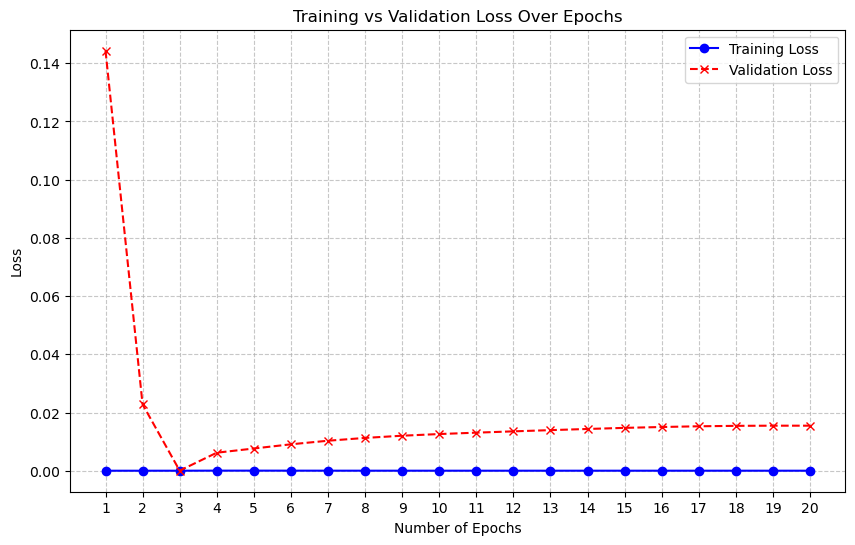



-------------------------------------------------------------------------------
Learning rate:  0.00016    Loop:  3
AMD Time interval  15 min Time period:  24 months
Batch size:  16 Number of workers:  0 Epochs:  200
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.059591).  Saving model ...
Epoch 10/200, Training Loss: 0.000005, Validation Loss: 0.106592
Validation loss decreased (0.059591 --> 0.003383).  Saving model ...
Epoch 20/200, Training Loss: 0.000013, Validation Loss: 0.005492
Validation loss decreased (0.003383 --> 0.000359).  Saving model ...
Epoch 30/200, Training Loss: 0.000163, Validation Loss: 0.000257
Epoch 40/200, Training Loss: 0.000126, Validation Loss: 0.000530
Epoch 50/200, Training Loss: 0.000269, Validation Loss: 0.002708
Epoch 60/200, Training Loss: 0.000274, Validation Loss: 0.003797
Epoch 70/200, Training Loss: 0.000287, Validati

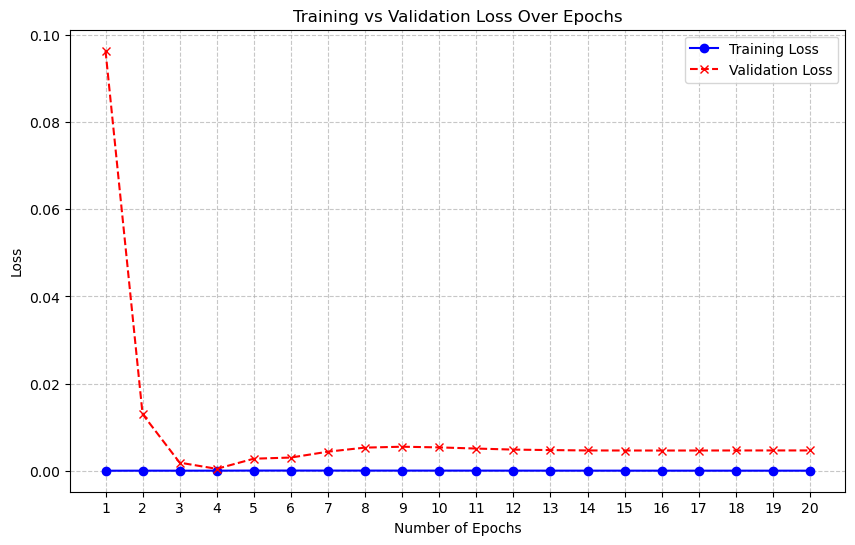



-------------------------------------------------------------------------------
Learning rate:  0.00014    Loop:  3
AMD Time interval  15 min Time period:  24 months
Batch size:  16 Number of workers:  0 Epochs:  200
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.049090).  Saving model ...
Epoch 10/200, Training Loss: 0.000006, Validation Loss: 0.087967
Validation loss decreased (0.049090 --> 0.002266).  Saving model ...
Epoch 20/200, Training Loss: 0.000007, Validation Loss: 0.002001
Validation loss decreased (0.002266 --> 0.000260).  Saving model ...
Epoch 30/200, Training Loss: 0.000026, Validation Loss: 0.000025
Epoch 40/200, Training Loss: 0.000030, Validation Loss: 0.000030
Epoch 50/200, Training Loss: 0.000019, Validation Loss: 0.000171
Epoch 60/200, Training Loss: 0.000013, Validation Loss: 0.000007
Epoch 70/200, Training Loss: 0.000014, Validati

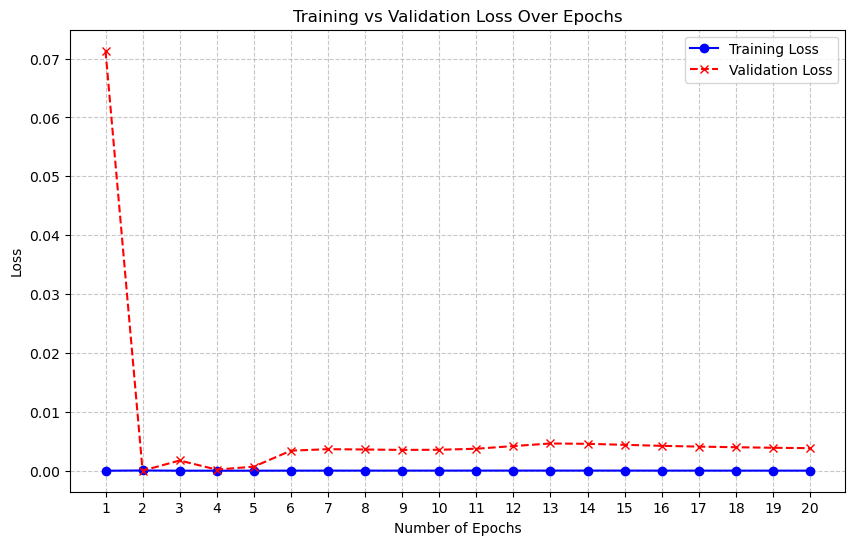



-------------------------------------------------------------------------------
Learning rate:  0.00012    Loop:  3
AMD Time interval  15 min Time period:  24 months
Batch size:  16 Number of workers:  0 Epochs:  200
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.055795).  Saving model ...
Epoch 10/200, Training Loss: 0.000007, Validation Loss: 0.099043
Validation loss decreased (0.055795 --> 0.002282).  Saving model ...
Epoch 20/200, Training Loss: 0.000059, Validation Loss: 0.001820
Validation loss decreased (0.002282 --> 0.001117).  Saving model ...
Epoch 30/200, Training Loss: 0.000018, Validation Loss: 0.001669
Validation loss decreased (0.001117 --> 0.000463).  Saving model ...
Epoch 40/200, Training Loss: 0.000010, Validation Loss: 0.000602
Validation loss decreased (0.000463 --> 0.000272).  Saving model ...
Epoch 50/200, Training Loss: 0.000010, 

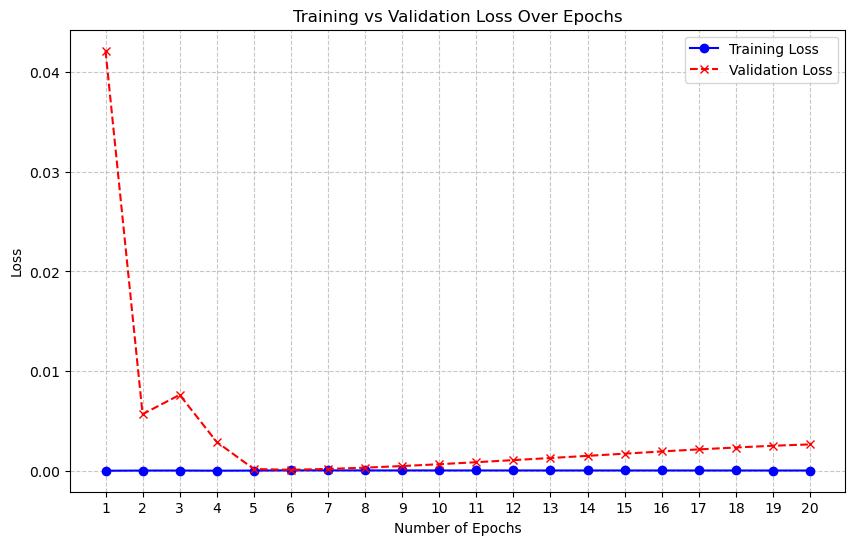

In [23]:
skip_this_step = False

if not skip_this_step:
    #test previous god perfoming rates learning rates
    learning_rate_list = [0.00018, 0.00016, 0.00014, 0.00012]
    best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_lr_in_loop = np.inf
    repeated_loops_per_lr = 3

    for lr in learning_rate_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"],sequence_len=seq, batch_size=batch_size, 
            num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_lr):
            training_loss_array = []
            validation_loss_array = []
            rnn = rnnSetup.init_RNN()
            loss = rnnSetup.trainAndTest(rnn)
            if best_lr_in_loop > loss:
                best_lr_in_loop = loss

        if best_lr_in_loop < best_lr[0][0]:
            best_lr[1] = best_lr[0]
            best_lr[0] = [best_lr_in_loop, lr]
        elif best_lr_in_loop < best_lr[1][0]:
            best_lr[1] = [best_lr_in_loop, lr]

        plot_loss(training_loss_array, validation_loss_array, epochs)

skip_this_step = False

In [24]:
#Stock variables when using yahoo finance api
if stock_data_source == "yahoo":
    stock_name = "AMD"
    stock_interval="5m"
    stock_period="7d"
    epochs = 100
    lr_scheduler_rate = 0.8
    beta1 = 0.9
    beta2 = 0.999

#Stock variables when using alpaca api
if stock_data_source == "alpaca":
    stock_name = "AMD"
    stock_interval="15"
    stock_period="12" #months
    epochs = 150
    lr_scheduler_rate = 0.1
    beta1 = 0.95
    beta2 = 0.999

batch_size = 16
num_workers = 0

In [27]:
skip_this_step = False

if not skip_this_step:
    #test previous god perfoming rates learning rates
    learning_rate_list = [0.00042]
    best_lr = [[np.inf, np.inf] , [np.inf, np.inf]] #record two pairs of [loss, learning rate] to tune learning rate later
    best_lr_in_loop = np.inf
    repeated_loops_per_lr = 3

    for lr in learning_rate_list:
        print("\n\n-------------------------------------------------------------------------------")
        print("Learning rate: ", lr, "   Loop: ", repeated_loops_per_lr)
        print(stock_name, "Time interval ", stock_interval, "min", "Time period: ", stock_period, 'months')
        print("Batch size: ", batch_size, "Number of workers: ", num_workers, "Epochs: ", epochs)
        print("Learning rate scheduler rate: ", lr_scheduler_rate)
        print("Beta1: ", beta1, "Beta2: ", beta2)
        print("-------------------------------------------------------------------------------")
        rnnSetup = RNN_initializer(retrieve=True, name=stock_name, recomp=True, nval=1, ival=[5, "m"], pval=[7,"d"], batch_size=batch_size, sequence_len=sequence_len,
            num_workers=num_workers, epochs=epochs, learning_rate=lr, lr_scheduler_rate=lr_scheduler_rate, beta1=beta1, beta2=beta2)
        for i in range(repeated_loops_per_lr):
            training_loss_array = []
            validation_loss_array = []
            rnn = rnnSetup.init_RNN()
            loss = rnnSetup.trainAndTest(rnn)
            if best_lr_in_loop > loss:
                best_lr_in_loop = loss

        if best_lr_in_loop < best_lr[0][0]:
            best_lr[1] = best_lr[0]
            best_lr[0] = [best_lr_in_loop, lr]
        elif best_lr_in_loop < best_lr[1][0]:
            best_lr[1] = [best_lr_in_loop, lr]

        plot_loss(training_loss_array, validation_loss_array, epochs)

skip_this_step = False



-------------------------------------------------------------------------------
Learning rate:  0.00042    Loop:  3
AMD Time interval  15 min Time period:  12 months
Batch size:  16 Number of workers:  0 Epochs:  150
Learning rate scheduler rate:  0.1
Beta1:  0.95 Beta2:  0.999
-------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.842850).  Saving model ...
Epoch 10/150, Training Loss: 0.147921, Validation Loss: 1.425848
Validation loss decreased (0.842850 --> 0.013239).  Saving model ...
Epoch 20/150, Training Loss: 0.069351, Validation Loss: 0.009343
Epoch 30/150, Training Loss: 0.063853, Validation Loss: 0.003963
Validation loss decreased (0.013239 --> 0.012889).  Saving model ...
Epoch 40/150, Training Loss: 0.026366, Validation Loss: 0.003244
Validation loss decreased (0.012889 --> 0.009638).  Saving model ...
Epoch 50/150, Training Loss: 0.018613, Validation Loss: 0.000699


KeyboardInterrupt: 

In [ ]:
#output,hidden = rnn1(price_tensor)
#print(output.shape)  # (1, 1, 128)
#print(hidden.shape)  # (2, 1, 128)
  # Predict 1 value from hidden_size=128

#prediction = fc(output[:, -1, :])  # Take output at last time step
#print(prediction)

## Test the Trained Network
---
Test your trained model on previously unseen data! Remember we have downloaded `train_data` and `test_data`. We will use `test_data` through `test_loader`.

A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)
---
Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

The following is working code, but you can make your own adjustments.

**TODO**: try to compare with ADAM optimizer

In [ ]:
#error = nn.MSELoss()
#optimizer = torch.optim.Adam(prediction.parameters(), lr=0.001)

#epochs = 50
#for epoch in range(epochs):
#    rnn1.train()
#    fc.train()
    
#      output,hidden = rnn1(price_tensor)
#    prediction = fc(output[:, -1, :])
#    loss = error(prediction, y_tensor)
    
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()

#    if (epoch+1) % 10 == 0:
#        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

In [29]:
test_loss = 0.0
value_correct = 0
error = nn.MSELoss()


bestRNN_lr[0].eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(bestRNN_lr_Setup[0].test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = bestRNN_lr[0](data)
    # calculate the batch loss
    loss = error(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # compare predictions to true label
    correct_tensor = output.eq(target.data.view_as(output))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    value_correct += 1
        
# average test loss
test_loss = test_loss/len(bestRNN_lr_Setup[0].test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: %2d%% (%2d/%2d)' % (test_loss,
    value_correct, len(bestRNN_lr_Setup[0].test_loader.dataset)))

Test Loss: 0.000884

Test Accuracy:  0% (195/3120)




-------------------------------------------------------------------------------
Target Values vs Predicted Values: 
Stock:  AMD
Batch size:  16
Target Values  [-0.48688235878944397, -0.4816160500049591, -0.5249276757240295, -0.5283729434013367, -0.5273885726928711, -0.5303416848182678, -0.5303416848182678, -0.5303367376327515, -0.5264042615890503, -0.5268964171409607, -0.5332947373390198, -0.5323103666305542, -0.5268964171409607, -0.5318182110786438, -0.5337868928909302, -0.5362477898597717]
Output Values  [-0.4810463786125183, -0.48177939653396606, -0.482158362865448, -0.5052831172943115, -0.5202968716621399, -0.5230806469917297, -0.5270209908485413, -0.5280082821846008, -0.5281324982643127, -0.5259969830513, -0.5251322984695435, -0.5287644863128662, -0.5298848152160645, -0.5268577933311462, -0.5284199118614197, -0.5306259989738464]
Test Loss:  0.0008842028600879414
-------------------------------------------------------------------------------


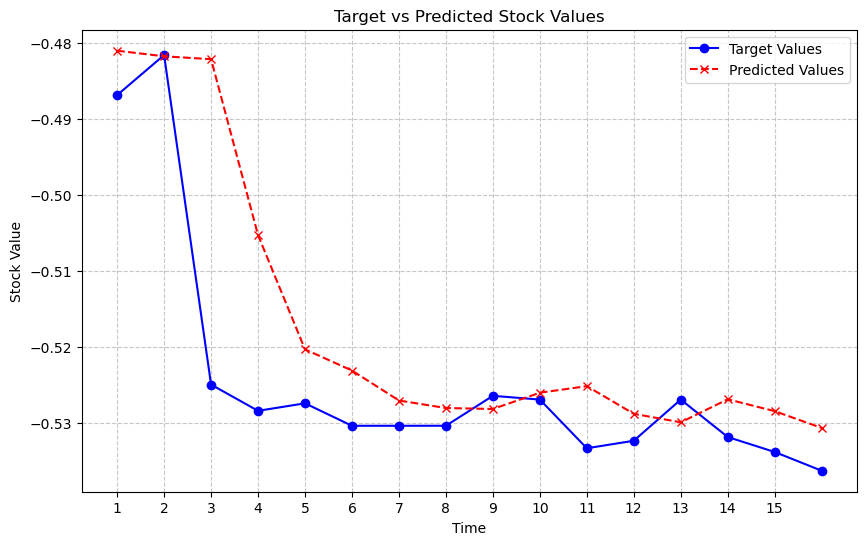

In [30]:
target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

print("\n\n-------------------------------------------------------------------------------")
print("Target Values vs Predicted Values: ")
print("Stock: ", stock_name)
print("Batch size: ", batch_size)
print("Target Values ", target_array)
print("Output Values ", output_array)
print("Test Loss: ", test_loss)
print("-------------------------------------------------------------------------------")

plot_target_vs_predicted_values(target_array, output_array, batch_size)

In [ ]:
target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

target_sum = 0
for i in target_array:
    target_sum += i
target_average = target_sum / len(target_array)

for i in range(len(target_array)):
    target_array[i] -= target_average

output_sum = 0
for i in output_array:
    output_sum += i
output_average = output_sum / len(output_array)

for i in range(len(output_array)):
    output_array[i] -= output_average

for i in range(len(output_array) - 1):
    output_array[i] = output_array[i + 1]

print("\n\n-------------------------------------------------------------------------------")
print("Normalized mean target values and predicted values to equal 0: ")
print("Shifted predicted values 1 to the left")
print("Target differnce of begining and end stock price: $", target_array[-1] - target_array[0])
print("Predicted differnce of begining and end stock price: $", output_array[-1] - output_array[0])
print("-------------------------------------------------------------------------------")



plot_target_vs_predicted_values(target_array[0:batch_size-1], output_array[0:batch_size-1], batch_size - 1)



In [ ]:
total_loss = 0
#iterate over test data
test_data = iter(bestRNN_lr_Setup[0].test_loader)
data, target = next(test_data)
if train_on_gpu:
    data, target = data.cuda(), target.cuda()
#forward pass: compute predicted outputs by passing inputs to the model
output = bestRNN_lr[0](data)
print(output)
print(target)
print("Output shape:", output.shape)
print("Target shape:", target.shape)
#calculate the batch loss
loss = error(output, target)
#update test loss
total_loss += loss.item()
test_loss += loss.item()/batch_size
#calculate test accuracy for each object class
#value_correct += 1

#average test loss
#test_loss = test_loss/len(bestRNN[0].test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

print("\n\n-------------------------------------------------------------------------------")
print("Target Values vs Predicted Values: ")
print("Stock: ", stock_name)
print("Batch size: ", batch_size)
print("Target Values ", target_array)
print("Output Values ", output_array)
print("Test Loss: ", test_loss)
print("-------------------------------------------------------------------------------")

plot_target_vs_predicted_values(target_array, output_array, batch_size)

target_array = []
output_array = []
for i in target:
    target_array.append(i.item())
for i in output:
    output_array.append(i.item())

target_sum = 0
for i in target_array:
    target_sum += i
target_average = target_sum / len(target_array)

for i in range(len(target_array)):
    target_array[i] -= target_average

output_sum = 0
for i in output_array:
    output_sum += i
output_average = output_sum / len(output_array)

for i in range(len(output_array)):
    output_array[i] -= output_average

for i in range(len(output_array) - 1):
    output_array[i] = output_array[i + 1]

print("\n\n-------------------------------------------------------------------------------")
print("Normalized mean target values and predicted values to equal 0: ")
print("Shifted predicted values 1 to the left")
print("Target differnce of begining and end stock price: $", target_array[-1] - target_array[0])
print("Predicted differnce of begining and end stock price: $", output_array[-1] - output_array[0])
print("-------------------------------------------------------------------------------")



plot_target_vs_predicted_values(target_array[0:batch_size-1], output_array[0:batch_size-1], batch_size - 1)
